In [1]:
suppressWarnings(suppressPackageStartupMessages({
    library(Seurat)
    library(Signac)
    library(EnsDb.Hsapiens.v86)
    library(dplyr)
    library(ggplot2)
    library(bedr)
    library(SeuratDisk)
    library(scales)
    library(reshape2)
    library(Hmisc)
    library(tidyr)
    library(crayon)
    library(tidyverse)
}))


# Definitions etc

In [2]:
set.seed(1234)
options(digits = 2)
stats <- c()


In [3]:
if (!exists("papermill_run")) {
    prj_name <- "Screen1_66guides"
    prj_path <- "S1/"
    data_subdir <- "/analysis/primary/cellranger/Screen1_66guides_L1/outs/"
    souporcell_clusters_path <-
        "S1/analysis/primary/souporcell/Lib_1/clusters.tsv"
    seurat_obj_path <-
        "S1/analysis/secondary/Lib_1/seurat_objects/"
    seurat_obj_fname <- "Screen1_66guides_Lib_1.h5seurat"

    library_name <- "Lib_1"
    save_seurat_h5 <- "NO"

}


In [4]:
data_path <- paste0(prj_path, data_subdir)
mx_path <- paste0(data_path, "/filtered_feature_bc_matrix/")
h5_path <- paste0(data_path, "/filtered_feature_bc_matrix.h5")
umi_thresholds_path <- paste0(
    data_path, "/crispr_analysis/protospacer_umi_thresholds.csv"
)
ps_calls_path <- paste0(
    data_path, "/crispr_analysis/protospacer_calls_per_cell.csv"
)
stats_out_path <- paste0(prj_path, "/analysis/primary/stats/")
save_h5_file <- paste0(seurat_obj_path, seurat_obj_fname)


In [5]:
custom_theme <- theme(
  plot.title = element_text(size = 16, hjust = 0.5),
  legend.key.size = unit(0.7, "cm"),
  legend.text = element_text(size = 14)
)


In [7]:
if (!file.exists(souporcell_clusters_path)) {
    cat(souporcell_clusters_path, "DOES NOT EXIST!")
    stopifnot(FALSE)
}


### Load 10x data

In [8]:
inputdata <- Read10X_h5(h5_path)


Genome matrix has multiple modalities, returning a list of matrices for this genome



In [9]:
# extract RNA and sgRNA data
rna_counts <- inputdata$`Gene Expression`
sgrna_counts <- inputdata$`CRISPR Guide Capture`


In [10]:
dim(rna_counts)
dim(sgrna_counts)


[1] 36602  9183

[1]  132 9183

In [11]:
n_cells_from_cellranger <- ncol(rna_counts)
n_protospacers <- nrow(sgrna_counts)
all_protospacer_ids <- colnames(sgrna_counts)
n_genes <- sum(rowSums(rna_counts) > 0)
cat(blue(prj_name, library_name), "\n")
cat(blue("#cells recovered:", n_cells_from_cellranger), "\n")
cat(blue("#genes recovered:", n_genes), "\n")
cat(blue("#protospacers in assay:", n_protospacers), "\n")

stats[["Screen"]] <- prj_name
stats[["Library"]] <- library_name
stats[["Cells_recovered"]] <- n_cells_from_cellranger
stats[["Genes_recovered"]] <- n_genes
stats[["Protospacers_in_assay"]] <- n_protospacers


Screen1_66guides Lib_1 
#cells recovered: 9183 
#genes recovered: 31871 
#protospacers in assay: 132 


# Visualize protospacer counts

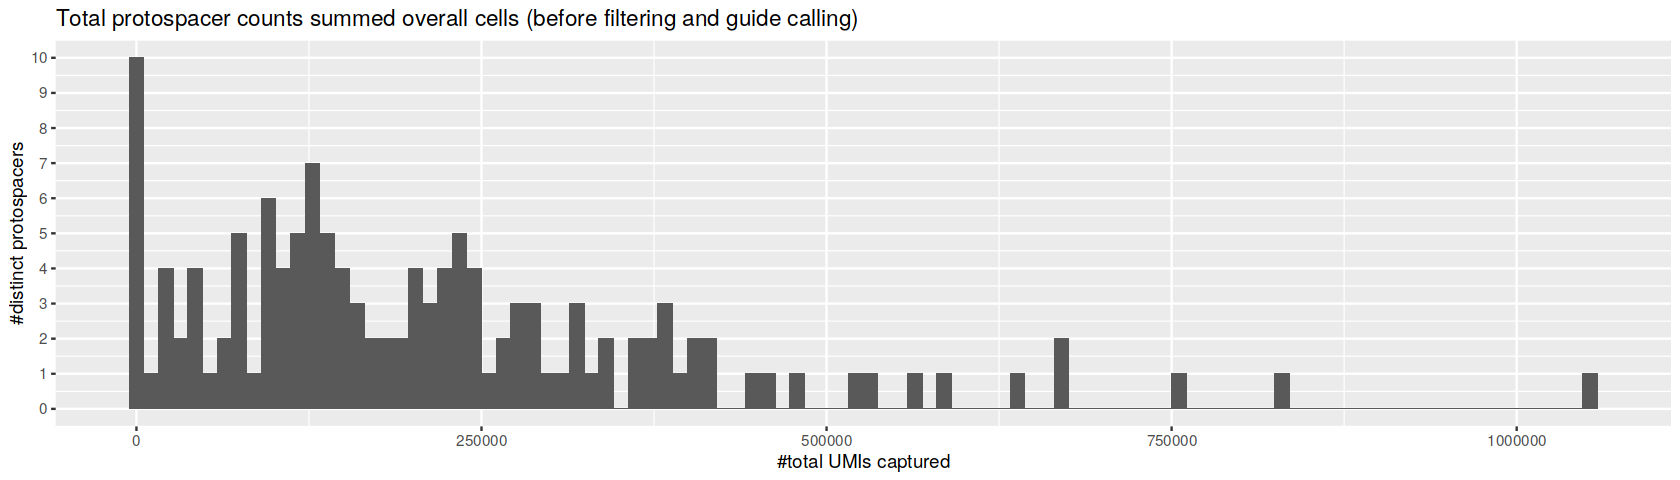

In [12]:
df_guide_counts <- data.frame(total_guide_count = rowSums(sgrna_counts))
row.names(df_guide_counts) <- row.names(sgrna_counts)

options(repr.plot.width = 14, repr.plot.height = 4)
ggplot(df_guide_counts, aes(x = total_guide_count)) +
    geom_histogram(bins = 100) +
    labs(
        title = "Total protospacer counts summed over" %+%
            "all cells (before filtering and guide calling)",
        x = "#total UMIs captured"
    ) +
    labs(y = "#distinct protospacers") +
    scale_y_continuous(breaks = seq(0, 10, by = 1))


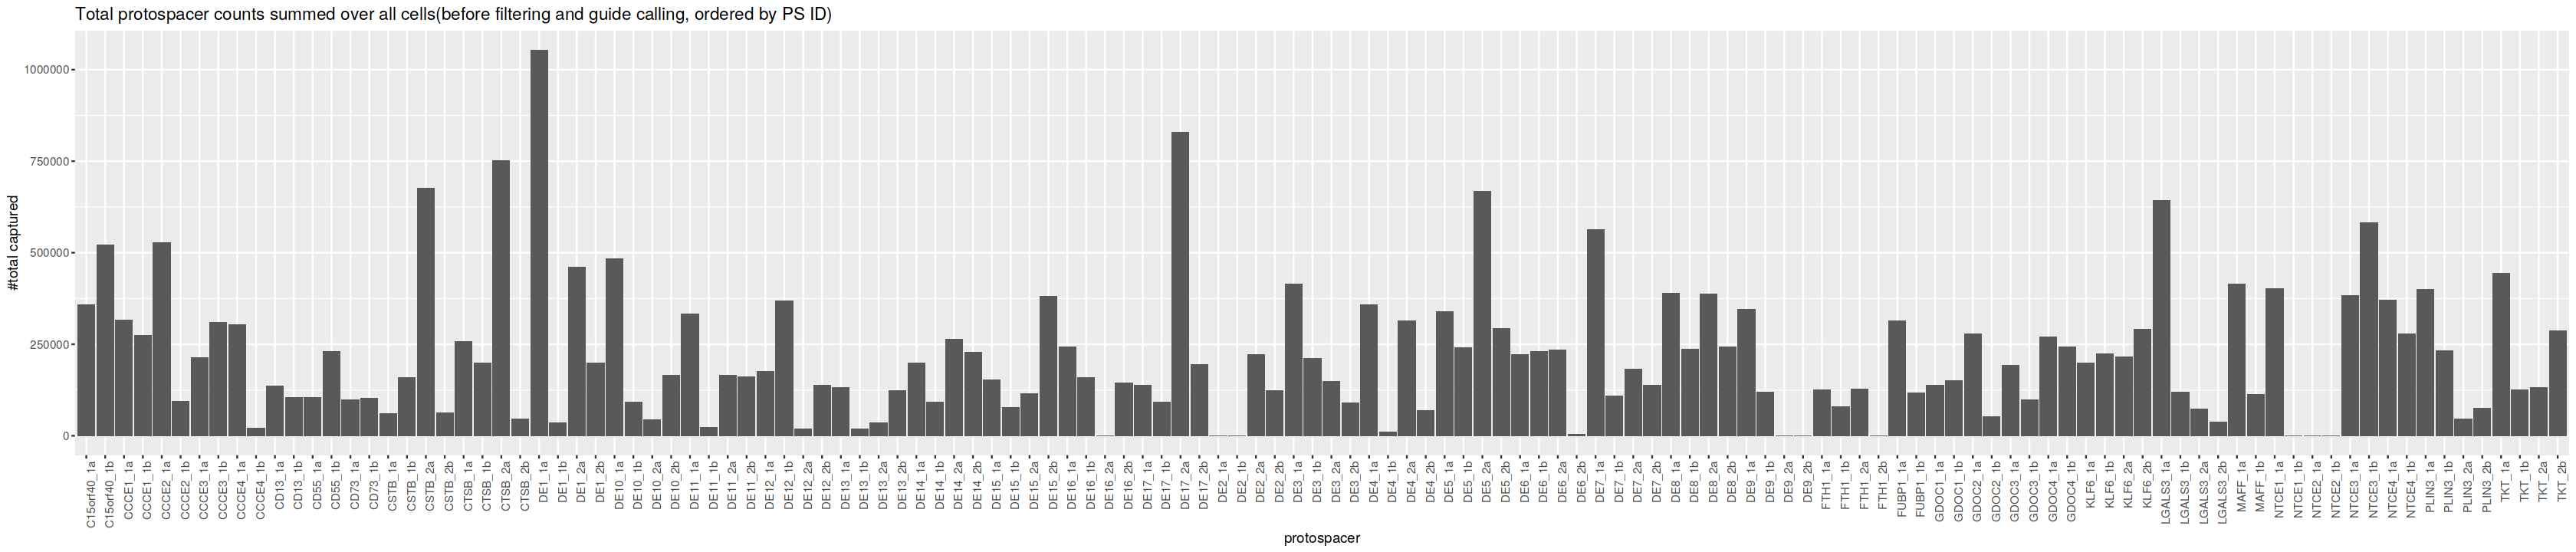

In [13]:
df_guide_counts_ordered <- df_guide_counts[order(df_guide_counts$total_guide_count), , drop = FALSE]
df_guide_counts_ordered$protospacer <- rownames(df_guide_counts_ordered)

options(repr.plot.width = 28, repr.plot.height = 6)
ggplot(df_guide_counts_ordered, aes(x = protospacer, y = total_guide_count)) +
    geom_bar(stat = "identity") +
    theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust = 1)) +
    labs(
        title = "Total protospacer counts summed over all cells" %+%
            "(before filtering and guide calling, ordered by PS ID)",
        x = "protospacer"
    ) +
    labs(y = "#total captured")


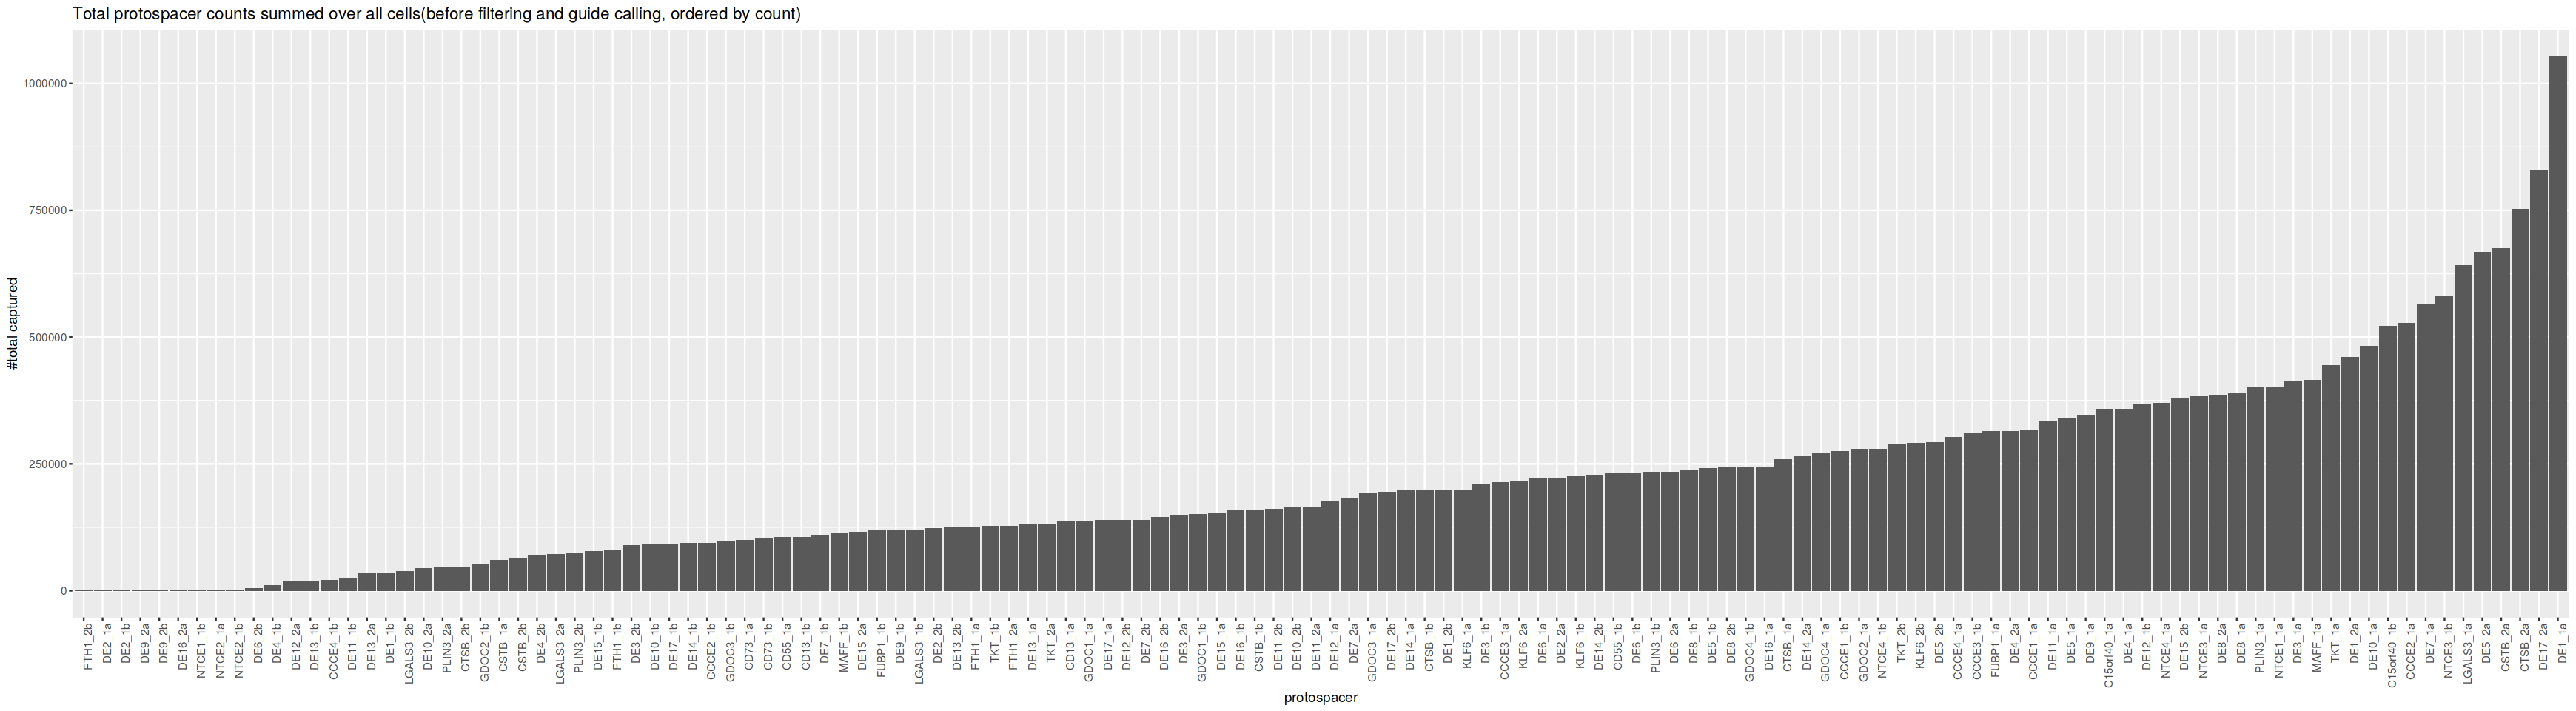

In [14]:
df_guide_counts_ordered$protospacer <- factor(df_guide_counts_ordered$protospacer, levels = df_guide_counts_ordered$protospacer)

options(repr.plot.width = 29, repr.plot.height = 8)
ggplot(df_guide_counts_ordered, aes(x = protospacer, y = total_guide_count)) +
    geom_bar(stat = "identity") +
    theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust = 1)) +
    labs(
        title = "Total protospacer counts summed over all cells" %+%
            "(before filtering and guide calling, ordered by count)",
        x = "protospacer"
    ) +
    labs(y = "#total captured")


In [15]:
head(df_guide_counts_ordered, 10)


total_guide_count protospacer
FTH1_2b     0              FTH1_2b    
DE2_1a      0              DE2_1a     
DE2_1b      0              DE2_1b     
DE9_2a      0              DE9_2a     
DE9_2b      0              DE9_2b     
DE16_2a     0              DE16_2a    
NTCE1_1b    0              NTCE1_1b   
NTCE2_1a    0              NTCE2_1a   
NTCE2_1b    0              NTCE2_1b   
DE6_2b   4074              DE6_2b

### Create Seurat object

In [16]:
seurat_unfiltered <- CreateSeuratObject(counts = rna_counts, project = prj_name)
sgrna_assay <- CreateAssayObject(counts = sgrna_counts)
seurat_unfiltered[["sgRNA"]] <- sgrna_assay
seurat_unfiltered$library <- library_name


Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"


### Get mitochondrial content

In [17]:
seurat_unfiltered[["percent.mt"]] <-
    PercentageFeatureSet(seurat_unfiltered, pattern = "^MT-")


In [18]:
DefaultAssay(seurat_unfiltered) <- "RNA"


## QC

### Get RNA counts per cell

In [19]:
counts_per_cell <- Matrix::colSums(rna_counts)
cat("counts per cell: ", counts_per_cell[1:20], "\n")


counts per cell:  25185 126446 43958 73018 63652 34135 58986 39723 41606 34297 85992 24157 53029 60204 44130 90248 42316 9404 53301 60509 


In [20]:
counts_per_gene <- Matrix::rowSums(rna_counts)
cat("counts per gene: ", counts_per_gene[1:20], "\n")


counts per gene:  3 0 4 156 9 0 224 3 0 2 0 1 0 3 2695 4 3176 149 463 115 


In [21]:
# count gene only if it has non-zero reads mapped.
genes_per_cell <- Matrix::colSums(rna_counts > 0)
# count gene only if it has non-zero reads mapped.
guides_per_cell <- Matrix::colSums(sgrna_counts > 0)

cat("counts for non-zero genes: ", genes_per_cell[1:5], "\n")
cat("counts for non-zero guides:", guides_per_cell[1:5], "\n")


counts for non-zero genes:  5887 11084 7411 9094 8614 
counts for non-zero guides: 19 28 31 22 20 


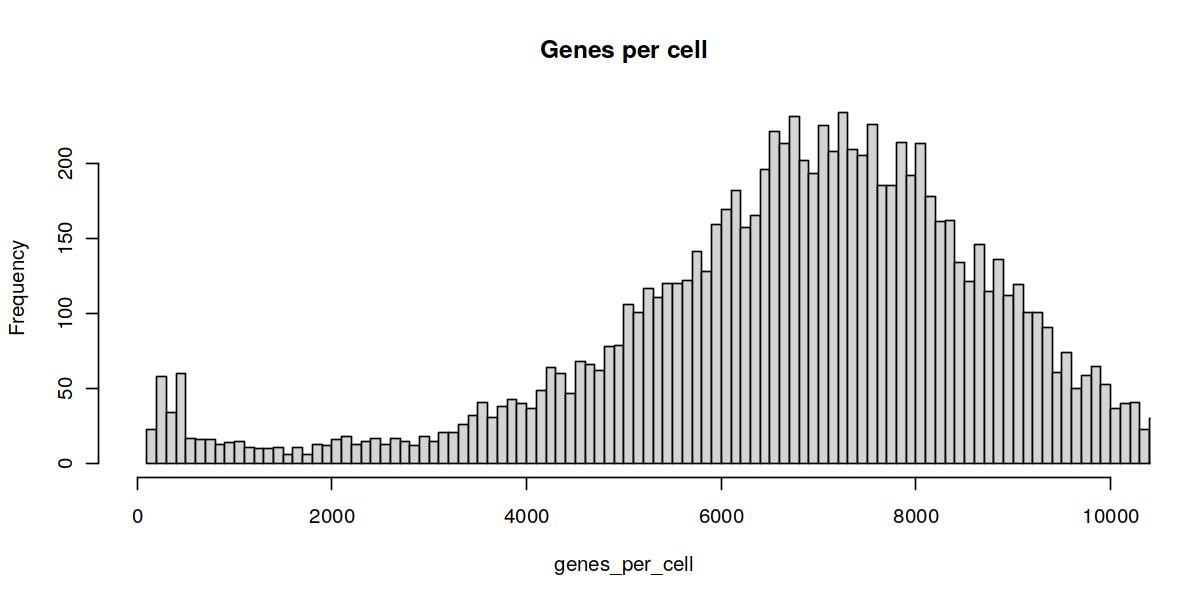

In [22]:
options(repr.plot.width = 10, repr.plot.height = 5)
plot_lin <- hist(genes_per_cell, main = "Genes per cell", breaks = 100, xlim = c(1, 10000))


### --

### Plot RNA counts per cell 

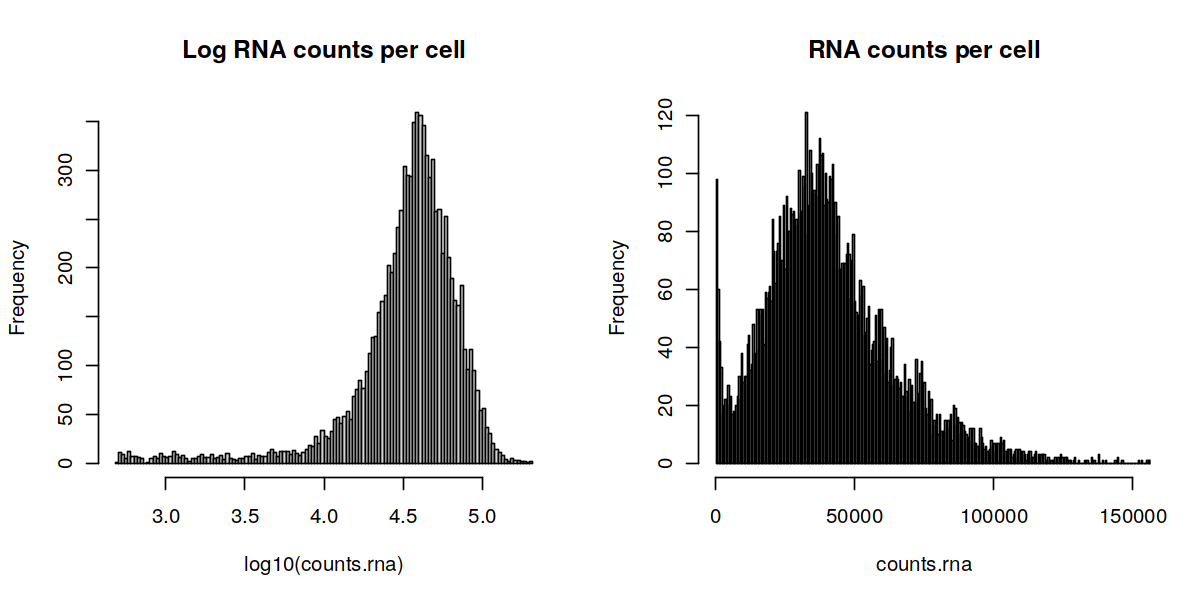

In [23]:
options(repr.plot.width = 10, repr.plot.height = 5)
par(mfrow = c(1, 2))
counts.rna <- seurat_unfiltered@meta.data$nCount_RNA
plot_log <- hist(
    log10(counts.rna),
    main = "Log RNA counts per cell", breaks = 100
)
plot_lin <- hist(
    counts.rna,
    main = "RNA counts per cell", breaks = 500, xlim = c(1, 150000)
)


### Plot sgRNA counts per cell 

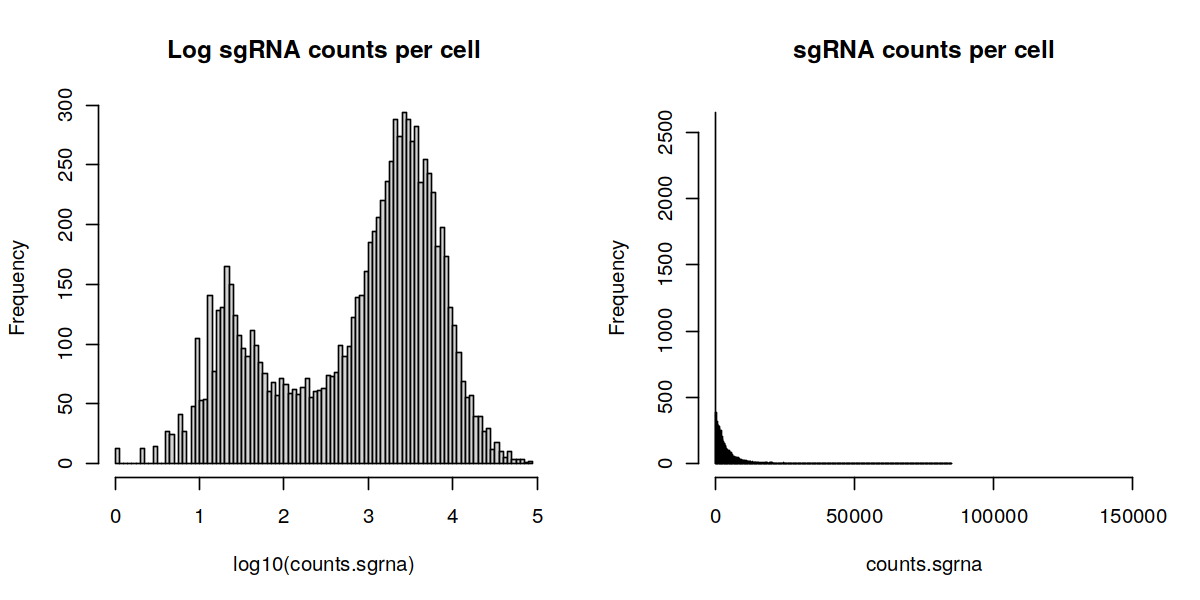

In [24]:
options(repr.plot.width = 10, repr.plot.height = 5)
par(mfrow = c(1, 2))
counts.sgrna <- seurat_unfiltered@meta.data$nCount_sgRNA
plot_log <- hist(
    log10(counts.sgrna),
    main = "Log sgRNA counts per cell", breaks = 100
)
plot_lin <- hist(
    counts.sgrna,
    main = "sgRNA counts per cell", breaks = 500, xlim = c(1, 150000)
)


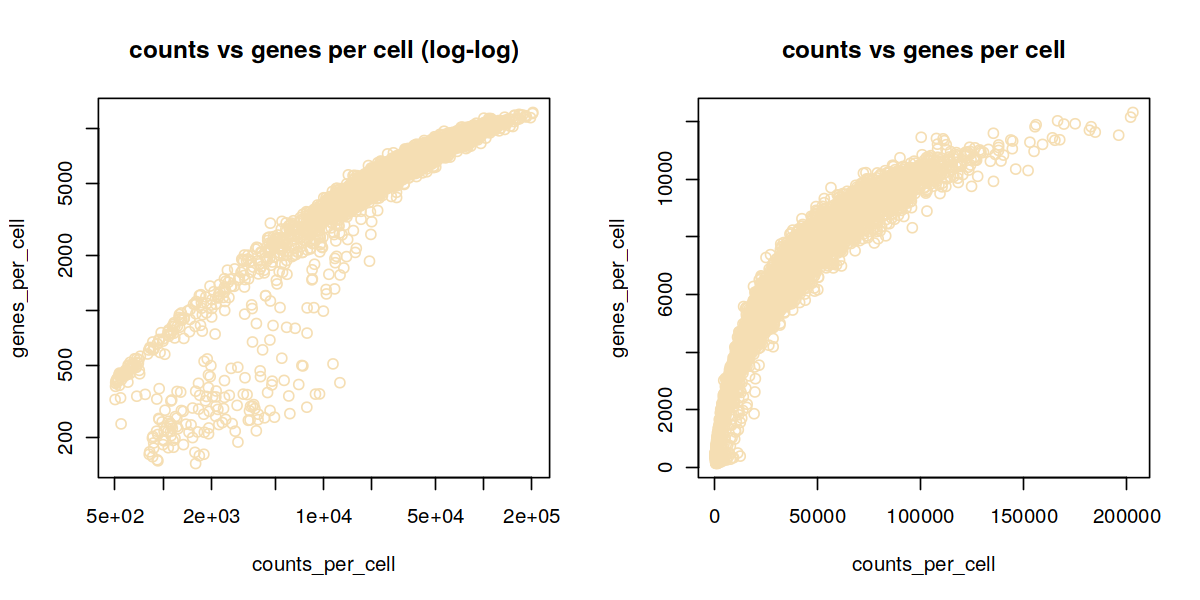

In [25]:
options(repr.plot.width = 10, repr.plot.height = 5)
par(mfrow = c(1, 2))
plot(counts_per_cell, genes_per_cell, log = "xy", col = "wheat")
title("counts vs genes per cell (log-log)")
plot(counts_per_cell, genes_per_cell, col = "wheat")
title("counts vs genes per cell")


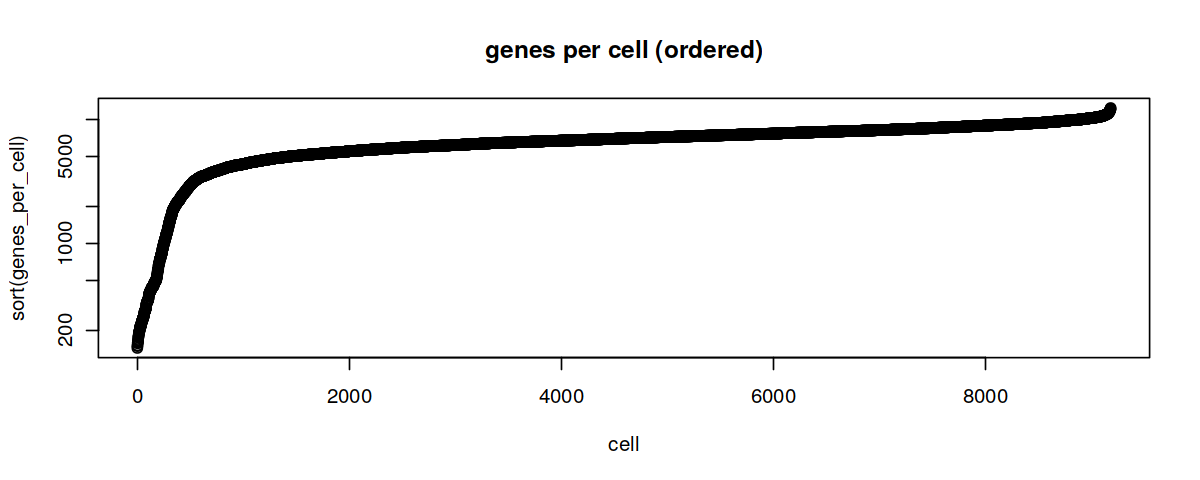

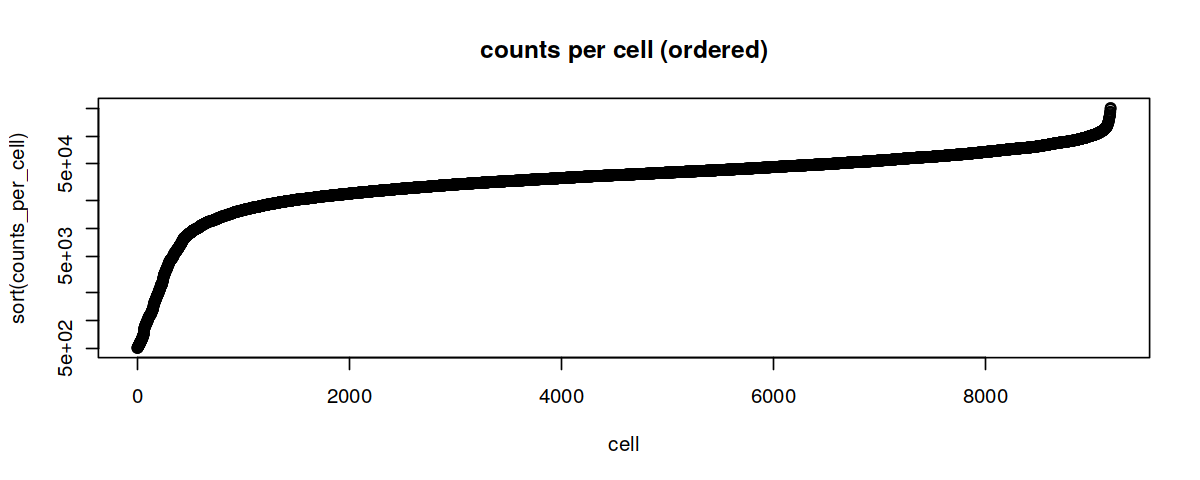

In [26]:
options(repr.plot.width = 10, repr.plot.height = 4)
plot(
    sort(genes_per_cell),
    xlab = "cell", log = "y", main = "genes per cell (ordered)"
)
plot(
    sort(counts_per_cell),
    xlab = "cell", log = "y", main = "counts per cell (ordered)"
)


In [27]:
# FeatureScatter(object = seurat_unfiltered, feature1 = "nCount_RNA", feature2 = "nCount_ATAC", log)


### QC using houskeeping genes

In [28]:
# Load the the list of house keeping genes
hkgenes <- read.table(
    "primary/S1_resources/housekeeping.txt",
    skip = 2
)
hkgenes <- as.vector(hkgenes$V1)


In [29]:
# remove hkgenes that were not found
hkgenes.found <- which(
    toupper(rownames(seurat_unfiltered@assays$RNA@data)) %in% hkgenes
)


In [30]:
num_hk_genes <- length(hkgenes.found)
num_hk_genes


[1] 95

In [31]:
n.expressed.hkgenes <- Matrix::colSums(
    seurat_unfiltered@assays$RNA@data[hkgenes.found, ] > 0
)


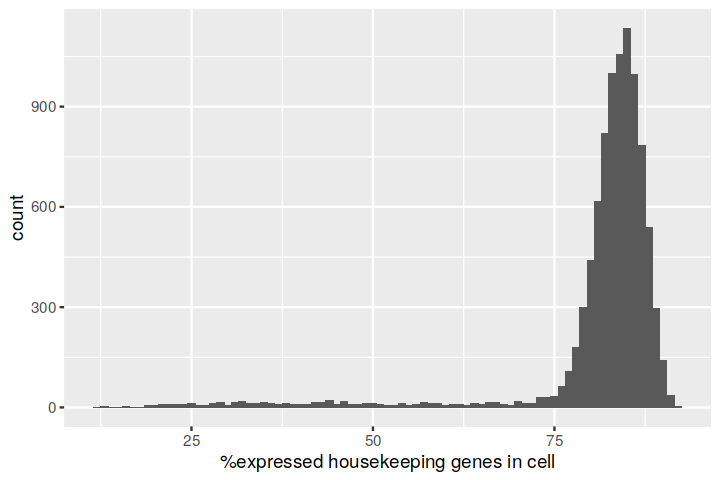

In [32]:
options(repr.plot.width = 6, repr.plot.height = 4)
df.expressed.hk <- data.frame(100 * n.expressed.hkgenes / num_hk_genes)
ggplot(df.expressed.hk, aes(n.expressed.hkgenes)) +
    geom_histogram(binwidth = 1) +
    labs(x = "%expressed housekeeping genes in cell")


### QC by mitochondrial genes

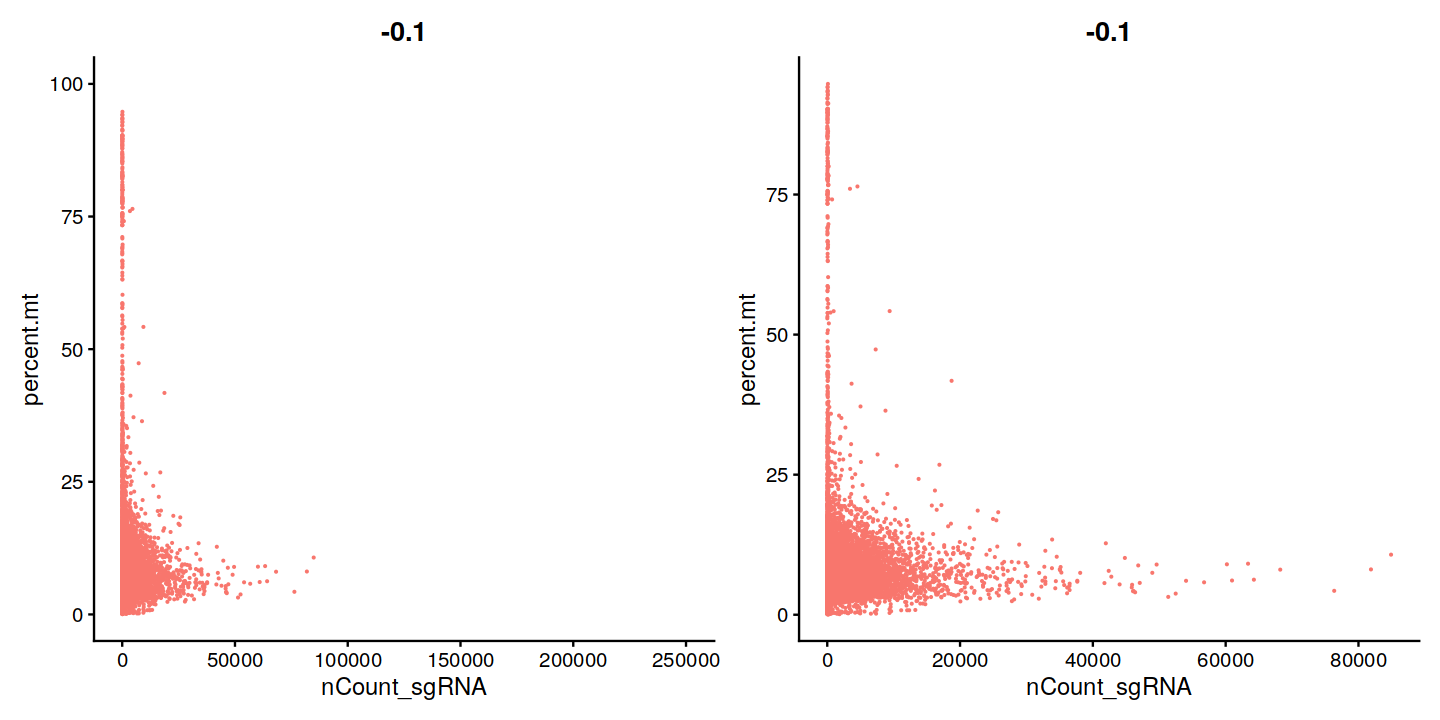

In [33]:
options(repr.plot.width = 12, repr.plot.height = 6)
plot1 <- FeatureScatter(
    seurat_unfiltered,
    feature1 = "nCount_sgRNA", feature2 = "percent.mt", pt.size = .1
)
plot1 + xlim(c(0, 250000)) + ylim(c(0, 100)) + NoLegend() | plot1 + NoLegend()


## Filtering

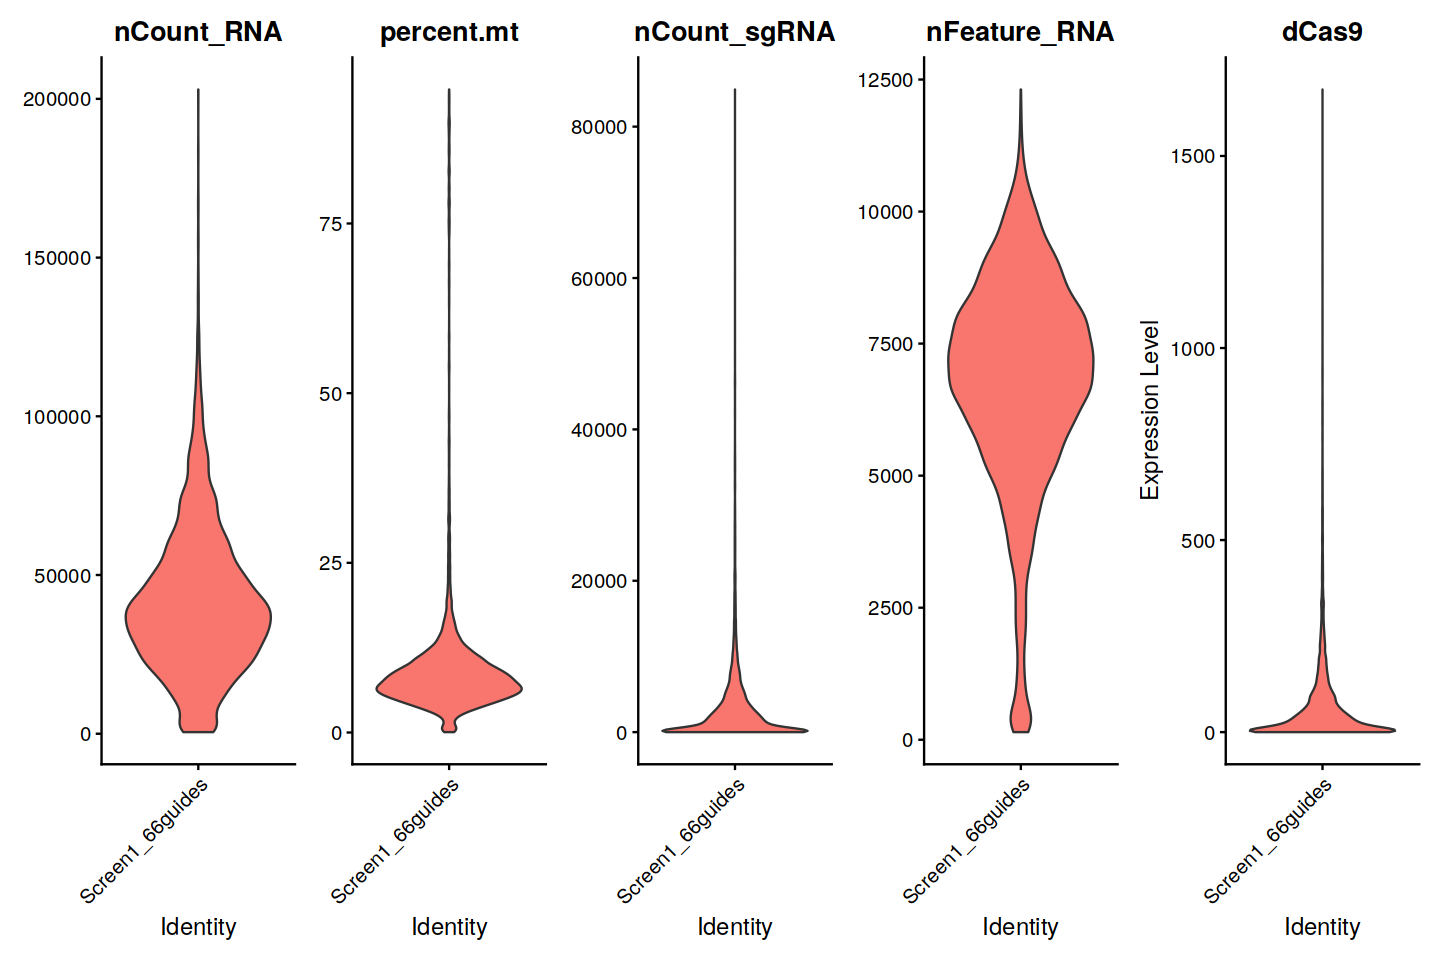

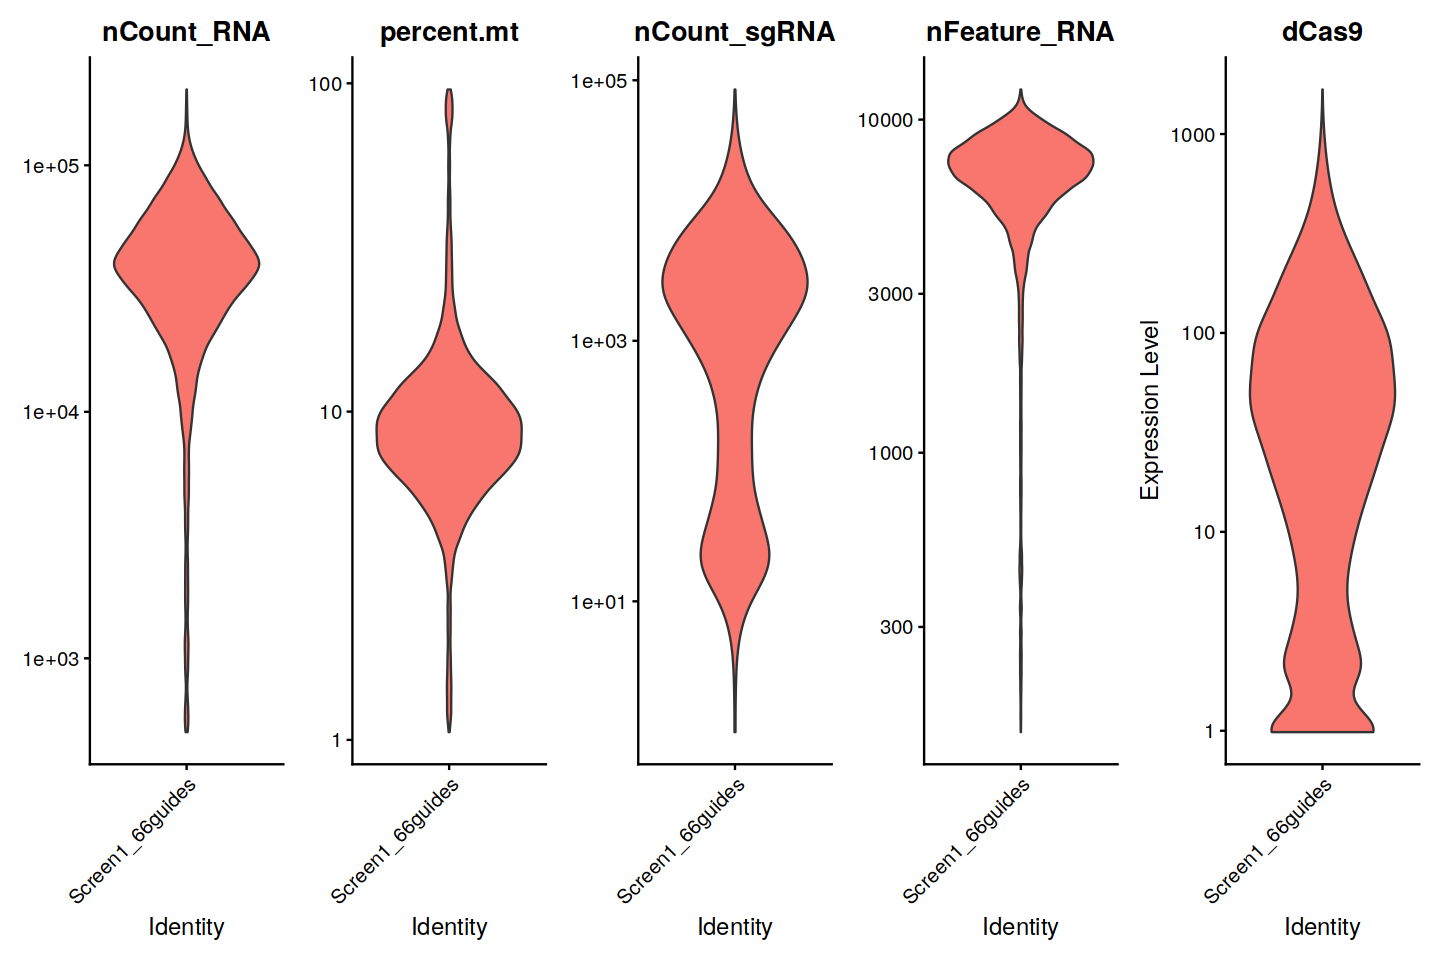

In [34]:
options(repr.plot.width = 12, repr.plot.height = 8)

VlnPlot(
  object = seurat_unfiltered,
  features =
    c("nCount_RNA", "percent.mt", "nCount_sgRNA", "nFeature_RNA", "dCas9"),
  ncol = 5,
  log = FALSE,
  pt.size = 0
)

VlnPlot(
  object = seurat_unfiltered,
  features =
    c("nCount_RNA", "percent.mt", "nCount_sgRNA", "nFeature_RNA", "dCas9"),
  ncol = 5,
  log = TRUE,
  pt.size = 0
)


### Filter out low quality cells

In [35]:
mads <- 3
min_mito_perc_threshold <- 3
min_genes_threshold <- 2000

desired_max_mito <- median(seurat_unfiltered$percent.mt) +
    mads * mad(seurat_unfiltered$percent.mt)
desired_min_mito <- median(seurat_unfiltered$percent.mt) -
    mads * mad(seurat_unfiltered$percent.mt)
desired_min_mito <- max(desired_min_mito, min_mito_perc_threshold)

desired_max_rna <- median(seurat_unfiltered$nCount_RNA) +
    mads * mad(seurat_unfiltered$nCount_RNA)
desired_min_rna <- median(seurat_unfiltered$nCount_RNA) -
    mads * mad(seurat_unfiltered$nCount_RNA)

desired_max_genes <- median(seurat_unfiltered$nFeature_RNA) +
    mads * mad(seurat_unfiltered$nFeature_RNA)
desired_min_genes <- median(seurat_unfiltered$nFeature_RNA) -
    mads * mad(seurat_unfiltered$nFeature_RNA)
desired_min_genes <- max(desired_min_genes, min_genes_threshold)


In [36]:
stats[["Max_mito_perc_threshold"]] <- desired_max_mito
stats[["Min_mito_perc_threshold"]] <- desired_min_mito

stats[["Max_n_RNA_threshold"]] <- desired_max_rna
stats[["Min_n_RNA_threshold"]] <- desired_min_rna

stats[["Max_n_genes_threshold"]] <- desired_max_genes
stats[["Min_n_genes_threshold"]] <- desired_min_genes


In [37]:
for (stat in names(stats)) {
    cat(blue(stat), ":", stats[[stat]], "\n")
}


Screen : Screen1_66guides 
Library : Lib_1 
Cells_recovered : 9183 
Genes_recovered : 31871 
Protospacers_in_assay : 132 
Max_mito_perc_threshold : 17 
Min_mito_perc_threshold : 3 
Max_n_RNA_threshold : 98499 
Min_n_RNA_threshold : -22205 
Max_n_genes_threshold : 12196 
Min_n_genes_threshold : 2000 


In [38]:
seurat <- subset(
  x = seurat_unfiltered,
  subset =
    nCount_RNA < desired_max_rna &
      nCount_RNA > desired_min_rna &
      percent.mt < desired_max_mito &
      percent.mt > desired_min_mito &
      nFeature_RNA < desired_max_genes &
      nFeature_RNA > desired_min_genes
)


In [39]:
stats[["Cells_after_QC_filtering"]] <- length(Cells(seurat))
stats[["Cells_with_sgRNA_count_less_than_100"]] <-
    length(Cells(subset(x = seurat, subset = nCount_sgRNA < 100)))


In [40]:
nrow(seurat_unfiltered@meta.data)
nrow(seurat@meta.data)


[1] 9183

[1] 8015

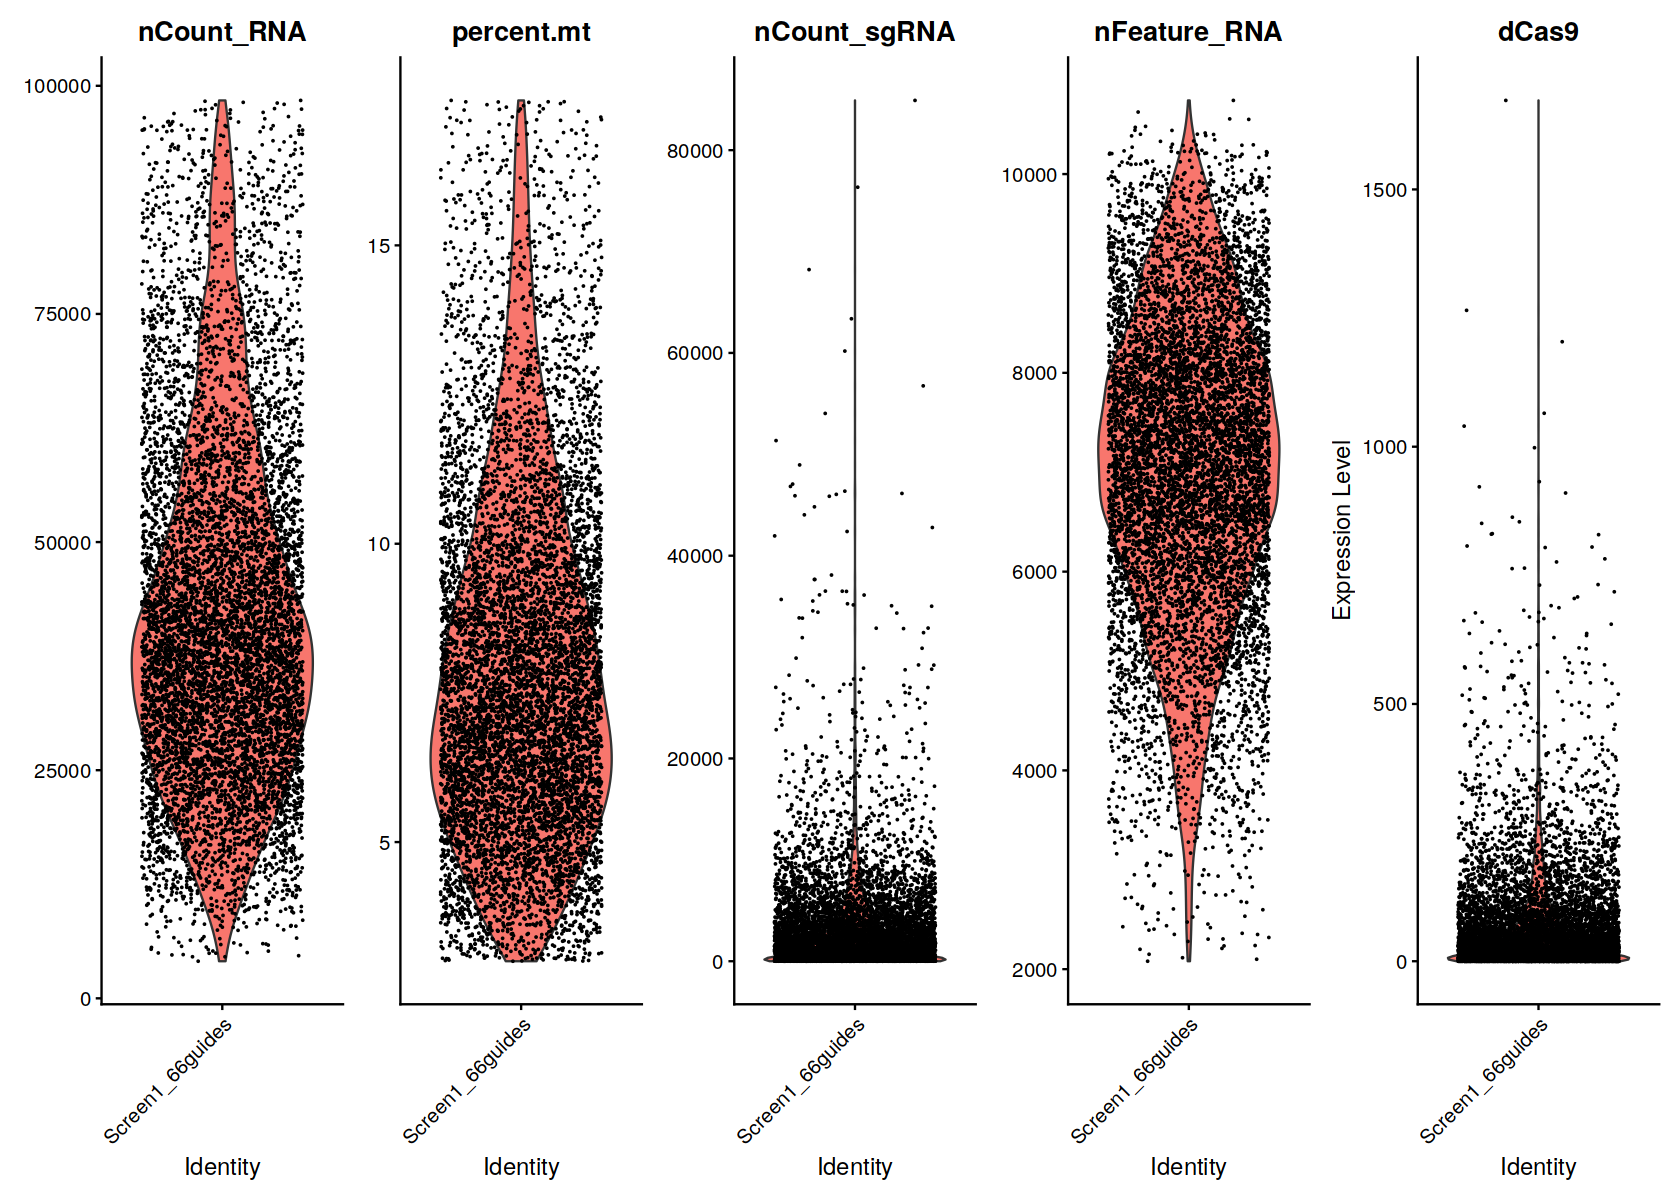

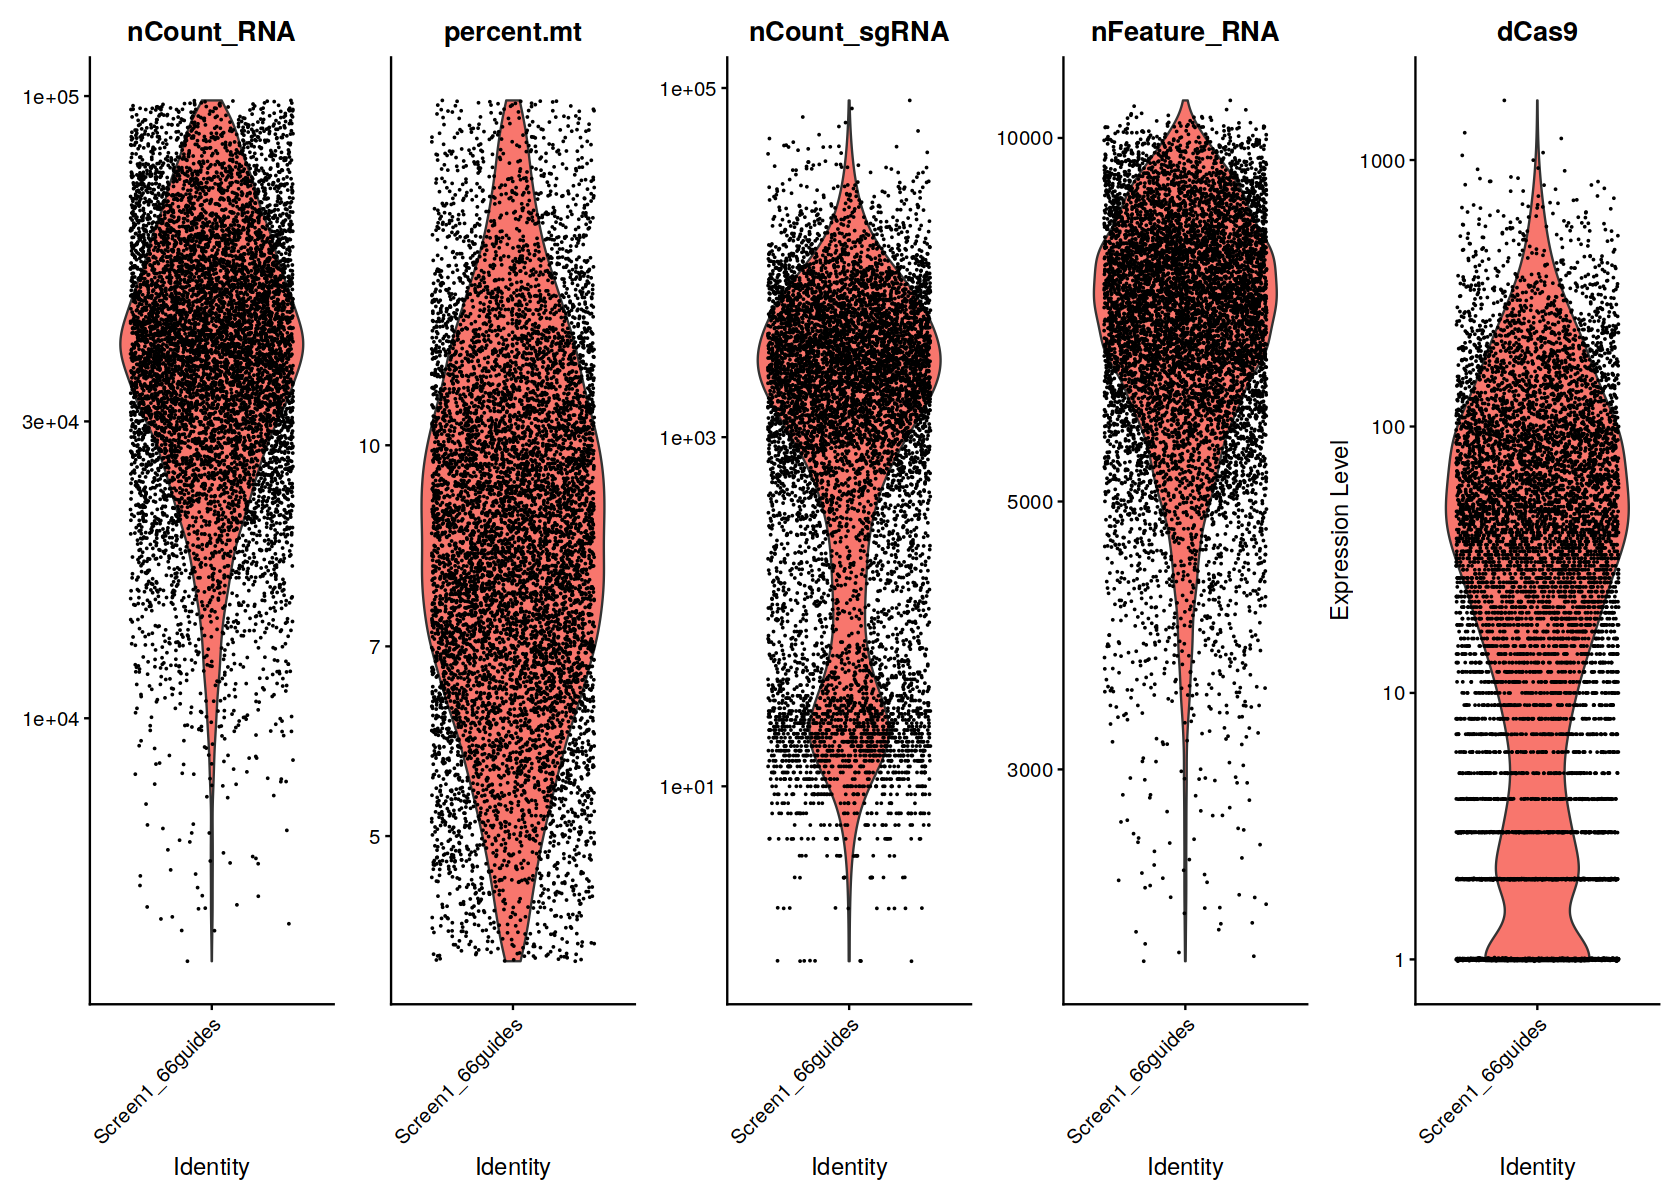

In [41]:
options(repr.plot.width = 14, repr.plot.height = 10)
VlnPlot(seurat,
        features =
                c("nCount_RNA", "percent.mt", "nCount_sgRNA", "nFeature_RNA", "dCas9"),
        ncol = 5,
        log = F,
        pt.size = .01
)

options(repr.plot.width = 14, repr.plot.height = 10)
VlnPlot(seurat,
        features = c("nCount_RNA", "percent.mt", "nCount_sgRNA", "nFeature_RNA", "dCas9"),
        ncol = 5,
        log = T,
        pt.size = .01
)


In [42]:
remaining_cells <- nrow(seurat@meta.data)
remaining_cells


[1] 8015

## Normalization, PCA, UMAP, SVD

### Normalize RNA assay

In [43]:
DefaultAssay(seurat) <- "RNA"
seurat <- SCTransform(
    seurat,
    method = "glmGamPoi",
    vst.flavor = "v2",
    verbose = FALSE
) %>%
    RunPCA() %>%
    RunUMAP(
        dims = 1:40,
        reduction.name = "umap.rna",
        reduction.key = "rnaUMAP_",
        verbose = FALSE
    )

# RunPCA(features = c(s.genes, g2m.genes)) %>%
# vars.to.regress = c('S.Score', 'G2M.Score')
# vars.to.regress = "percent.mt",


PC_ 1 
Positive:  FTL, APOE, CRYAB, MT1X, FTH1, SOD2, S100A1, PLIN2, SERPINA1, G0S2 
	   FN1, MT1E, dCas9, FGB, CTSB, RARRES2, SERPINE1, VCAM1, GPX3, NUPR1 
	   MGST1, RRAD, AKR1C3, VGF, ITPKA, IL32, SQSTM1, ZIM3, CDH6, SPP1 
Negative:  ERBB4, MECOM, KCNIP4, FAM155A, WFDC2, AC019197.1, MAL, BST2, KITLG, PDE1A 
	   SFRP1, S100A2, KRT19, PKHD1, SKAP1, CSGALNACT1, ACSL4, PCSK5, CENPF, SNED1 
	   TFCP2L1, DENND2A, TFAP2B, HOXB3, MKI67, SPON1, ITGA2, ARHGEF38, SCN2A, SGIP1 
PC_ 2 
Positive:  CENPF, MKI67, TUBA1B, TOP2A, HMGB2, TPX2, ASPM, CCNB1, DLGAP5, HMMR 
	   PCLAF, NUSAP1, CEP55, ANLN, CKS2, PBK, PRC1, PTTG1, TUBB4B, CDKN3 
	   GTSE1, H2AFZ, UBE2S, BIRC5, RRM2, CDK1, CDC20, UBE2C, CENPE, KIF20B 
Negative:  KCNIP4, MALAT1, dCas9, NEAT1, ERBB4, MECOM, AC079352.1, ADAMTS9-AS2, LINC01320, PDE1A 
	   MDM2, PTCHD4, FAM155A, LRP1B, ZIM3, PDE4D, LINC02532, PKHD1, WFDC2, MAGI2 
	   FKBP5, PKP4, AC019197.1, KCNJ16, CPEB2, FTX, GBE1, FHIT, NRXN3, PTH2R 
PC_ 3 
Positive:  WFDC2, ERBB4, KCNIP4, FXY

### Normalize sgRNA counts

In [44]:
seurat <- NormalizeData(
    seurat,
    assay = "sgRNA",
    normalization.method = "CLR"
)


Normalizing across features



In [45]:
head(seurat, 5)


orig.ident       nCount_RNA nFeature_RNA nCount_sgRNA
AAACCCAAGAGCAGCT-1 Screen1_66guides 25185      5887         3237        
AAACCCAAGCTTAAGA-1 Screen1_66guides 43958      7411         2844        
AAACCCAAGGCTGTAG-1 Screen1_66guides 73018      9094         1908        
AAACCCAAGGTTTACC-1 Screen1_66guides 63652      8614         2088        
AAACCCAAGTGATCGG-1 Screen1_66guides 34135      6635            7        
                   nFeature_sgRNA library percent.mt nCount_SCT nFeature_SCT
AAACCCAAGAGCAGCT-1 19             Lib_1    6.7       38025      5888        
AAACCCAAGCTTAAGA-1 31             Lib_1    9.0       40323      7326        
AAACCCAAGGCTGTAG-1 22             Lib_1   14.0       40064      7760        
AAACCCAAGGTTTACC-1 20             Lib_1    6.2       40472      8119        
AAACCCAAGTGATCGG-1  7             Lib_1   15.5       38062      6585

#### Group PS counts by construct

In [46]:
DefaultAssay(seurat) <- "sgRNA"
df_guide_counts <- as.data.frame(t(seurat[["sgRNA"]]@counts))
rownames(df_guide_counts) <- NULL
head(df_guide_counts, 2)
ncol(df_guide_counts)


CD13-1a CD13-1b CD55-1a CD55-1b CD73-1a CD73-1b FUBP1-1a FUBP1-1b C15orf40-1a
1   0       0     0       0       0       0       941      0        3          
2 882     593     0       0       0       0        20      0        0          
  C15orf40-1b ⋯ GDOC4-1a GDOC4-1b CCCE1-1a CCCE1-1b CCCE2-1a CCCE2-1b CCCE3-1a
1 0           ⋯ 0        0        0        1        0        0        0       
2 0           ⋯ 1        0        1        0        0        0        0       
  CCCE3-1b CCCE4-1a CCCE4-1b
1  0       1        0       
2 22       0        0

[1] 132

In [47]:
DefaultAssay(seurat) <- "sgRNA"
df_guide_counts <- as.data.frame(t(seurat[["sgRNA"]]@counts))
rownames(df_guide_counts) <- NULL
ps_ids <- colnames(df_guide_counts)
ps_ids <- gsub("-1a", "", ps_ids)
ps_ids <- gsub("-1b", "", ps_ids)
ps_ids <- gsub("-2a", "", ps_ids)
ps_ids <- gsub("-2b", "", ps_ids)
ps_ids <- unique(ps_ids)

for (ps_id in ps_ids) {
    df_guide_counts[, ps_id] <- rowSums(select(df_guide_counts, contains(ps_id)))
}
ps_ids
length(ps_ids)


[1] "CD13"     "CD55"     "CD73"     "FUBP1"    "C15orf40" "MAFF"    
 [7] "FTH1"     "PLIN3"    "TKT"      "LGALS3"   "CSTB"     "CTSB"    
[13] "KLF6"     "DE1"      "DE2"      "DE3"      "DE4"      "DE5"     
[19] "DE6"      "DE7"      "DE8"      "DE9"      "DE10"     "DE11"    
[25] "DE12"     "DE13"     "DE14"     "DE15"     "DE16"     "DE17"    
[31] "NTCE1"    "NTCE2"    "NTCE3"    "NTCE4"    "GDOC1"    "GDOC2"   
[37] "GDOC3"    "GDOC4"    "CCCE1"    "CCCE2"    "CCCE3"    "CCCE4"

[1] 42

In [48]:
df_guides_by_target <- df_guide_counts[, ps_ids]
df_guides_by_target$total_targets <- rowSums(df_guides_by_target != 0)
head(df_guides_by_target)
ncol(df_guides_by_target)


CD13 CD55 CD73 FUBP1 C15orf40 MAFF FTH1 PLIN3 TKT  LGALS3 ⋯ NTCE4 GDOC1 GDOC2
1    0 0    0    941   3        1     0   0        0 0      ⋯ 0     0     0    
2 1475 0    0     20   0        0     0   0        0 2      ⋯ 4     0     0    
3    0 1    0      1   0        0     1   0     1887 0      ⋯ 1     0     0    
4    2 0    1      1   0        0     0   0        1 0      ⋯ 0     0     0    
5    0 0    0      0   0        0     0   1        1 0      ⋯ 0     0     0    
6  359 0    0      0   0        0    39   3        0 6      ⋯ 0     0     0    
  GDOC3 GDOC4 CCCE1 CCCE2 CCCE3 CCCE4 total_targets
1 0     0        1  0      0    1     16           
2 0     1        1  0     22    0     22           
3 0     1        0  1      0    0     18           
4 0     1        1  0      0    0     19           
5 0     0        0  0      0    0      7           
6 0     1     2367  0      1    1     27

[1] 43

#### Group PS counts by construct

In [49]:
DefaultAssay(seurat) <- "sgRNA"
df_guide_counts <- as.data.frame(t(seurat[["sgRNA"]]@counts))
rownames(df_guide_counts) <- NULL

ps_ids <- colnames(df_guide_counts)
ps_ids <- gsub("-1a", "-1", ps_ids)
ps_ids <- gsub("-1b", "-1", ps_ids)
ps_ids <- gsub("-2a", "-2", ps_ids)
ps_ids <- gsub("-2b", "-2", ps_ids)
ps_ids <- unique(ps_ids)

for (ps_id in ps_ids) {
    df_guide_counts[, ps_id] <- rowSums(select(df_guide_counts, contains(ps_id)))
}
ps_ids
length(ps_ids)


[1] "CD13-1"     "CD55-1"     "CD73-1"     "FUBP1-1"    "C15orf40-1"
 [6] "MAFF-1"     "FTH1-1"     "FTH1-2"     "PLIN3-1"    "PLIN3-2"   
[11] "TKT-1"      "TKT-2"      "LGALS3-1"   "LGALS3-2"   "CSTB-1"    
[16] "CSTB-2"     "CTSB-1"     "CTSB-2"     "KLF6-1"     "KLF6-2"    
[21] "DE1-1"      "DE1-2"      "DE2-1"      "DE2-2"      "DE3-1"     
[26] "DE3-2"      "DE4-1"      "DE4-2"      "DE5-1"      "DE5-2"     
[31] "DE6-1"      "DE6-2"      "DE7-1"      "DE7-2"      "DE8-1"     
[36] "DE8-2"      "DE9-1"      "DE9-2"      "DE10-1"     "DE10-2"    
[41] "DE11-1"     "DE11-2"     "DE12-1"     "DE12-2"     "DE13-1"    
[46] "DE13-2"     "DE14-1"     "DE14-2"     "DE15-1"     "DE15-2"    
[51] "DE16-1"     "DE16-2"     "DE17-1"     "DE17-2"     "NTCE1-1"   
[56] "NTCE2-1"    "NTCE3-1"    "NTCE4-1"    "GDOC1-1"    "GDOC2-1"   
[61] "GDOC3-1"    "GDOC4-1"    "CCCE1-1"    "CCCE2-1"    "CCCE3-1"   
[66] "CCCE4-1"

[1] 66

In [50]:
df_guides_by_vector <- df_guide_counts[, ps_ids]
df_guides_by_vector$total_vectors <- rowSums(df_guides_by_vector != 0)
head(df_guides_by_vector)
ncol(df_guides_by_vector)


CD13-1 CD55-1 CD73-1 FUBP1-1 C15orf40-1 MAFF-1 FTH1-1 FTH1-2 PLIN3-1 PLIN3-2
1    0   0      0      941     3          1      0       0     0       0      
2 1475   0      0       20     0          0      0       0     0       0      
3    0   1      0        1     0          0      0       1     0       0      
4    2   0      1        1     0          0      0       0     0       0      
5    0   0      0        0     0          0      0       0     1       0      
6  359   0      0        0     0          0      4      35     3       0      
  ⋯ NTCE4-1 GDOC1-1 GDOC2-1 GDOC3-1 GDOC4-1 CCCE1-1 CCCE2-1 CCCE3-1 CCCE4-1
1 ⋯ 0       0       0       0       0          1    0        0      1      
2 ⋯ 4       0       0       0       1          1    0       22      0      
3 ⋯ 1       0       0       0       1          0    1        0      0      
4 ⋯ 0       0       0       0       1          1    0        0      0      
5 ⋯ 0       0       0       0       0          0    0        0      0      
6 ⋯ 0       0       0       0       1       2367    0        1      1      
  total_vectors
1 18           
2 26           
3 21           
4 19           
5  6           
6 32

[1] 67


## Plot PS b vs a 

In [51]:
guide_names <- sort(colnames(df_guide_counts))
guides_a <- guide_names[grep("a$", guide_names)]
guides_b <- guide_names[grep("b$", guide_names)]


Count a and b guides for each target

In [52]:
df_pair <- df_guide_counts
df_pair_a <- gather(df_pair[, guides_a], key = "PS_a", value = "a")
df_pair_b <- gather(df_pair[, guides_b], key = "PS_b", value = "b")

df_pair <- cbind(df_pair_a, df_pair_b)
head(df_pair, 2)


PS_a        a PS_b        b
1 C15orf40-1a 3 C15orf40-1b 0
2 C15orf40-1a 0 C15orf40-1b 0

Get a and b sums for each target

In [53]:
df_a_sums <- df_pair %>%
    group_by(PS_a) %>%
    summarise(Freq = sum(a))
df_a_sums$PS_a <- gsub("a$", "", as.vector(df_a_sums$PS_a))
colnames(df_a_sums) <- c("Target", "a")

df_b_sums <- df_pair %>%
    group_by(PS_b) %>%
    summarise(Freq = sum(b))
df_b_sums$PS_b <- gsub("b$", "", as.vector(df_b_sums$PS_b))
colnames(df_b_sums) <- c("Target", "b")

df_sums <- merge(df_a_sums, df_b_sums, on = Target)

head(df_sums)


Target     a      b     
1 C15orf40-1 288910 430267
2 CCCE1-1    285546 235922
3 CCCE2-1    435695  82944
4 CCCE3-1    185280 265997
5 CCCE4-1    268232  17578
6 CD13-1     110837  94006

In [54]:
df_pair$PS <- gsub("a$", "", as.vector(df_pair$PS_a))
df_pair <- subset(df_pair, select = c(PS, a, b))

select_nonzero <- (df_pair$a > 0) | (df_pair$b > 0)
df_pair <- df_pair[select_nonzero, ]
rownames(df_pair) <- NULL


### Plot 

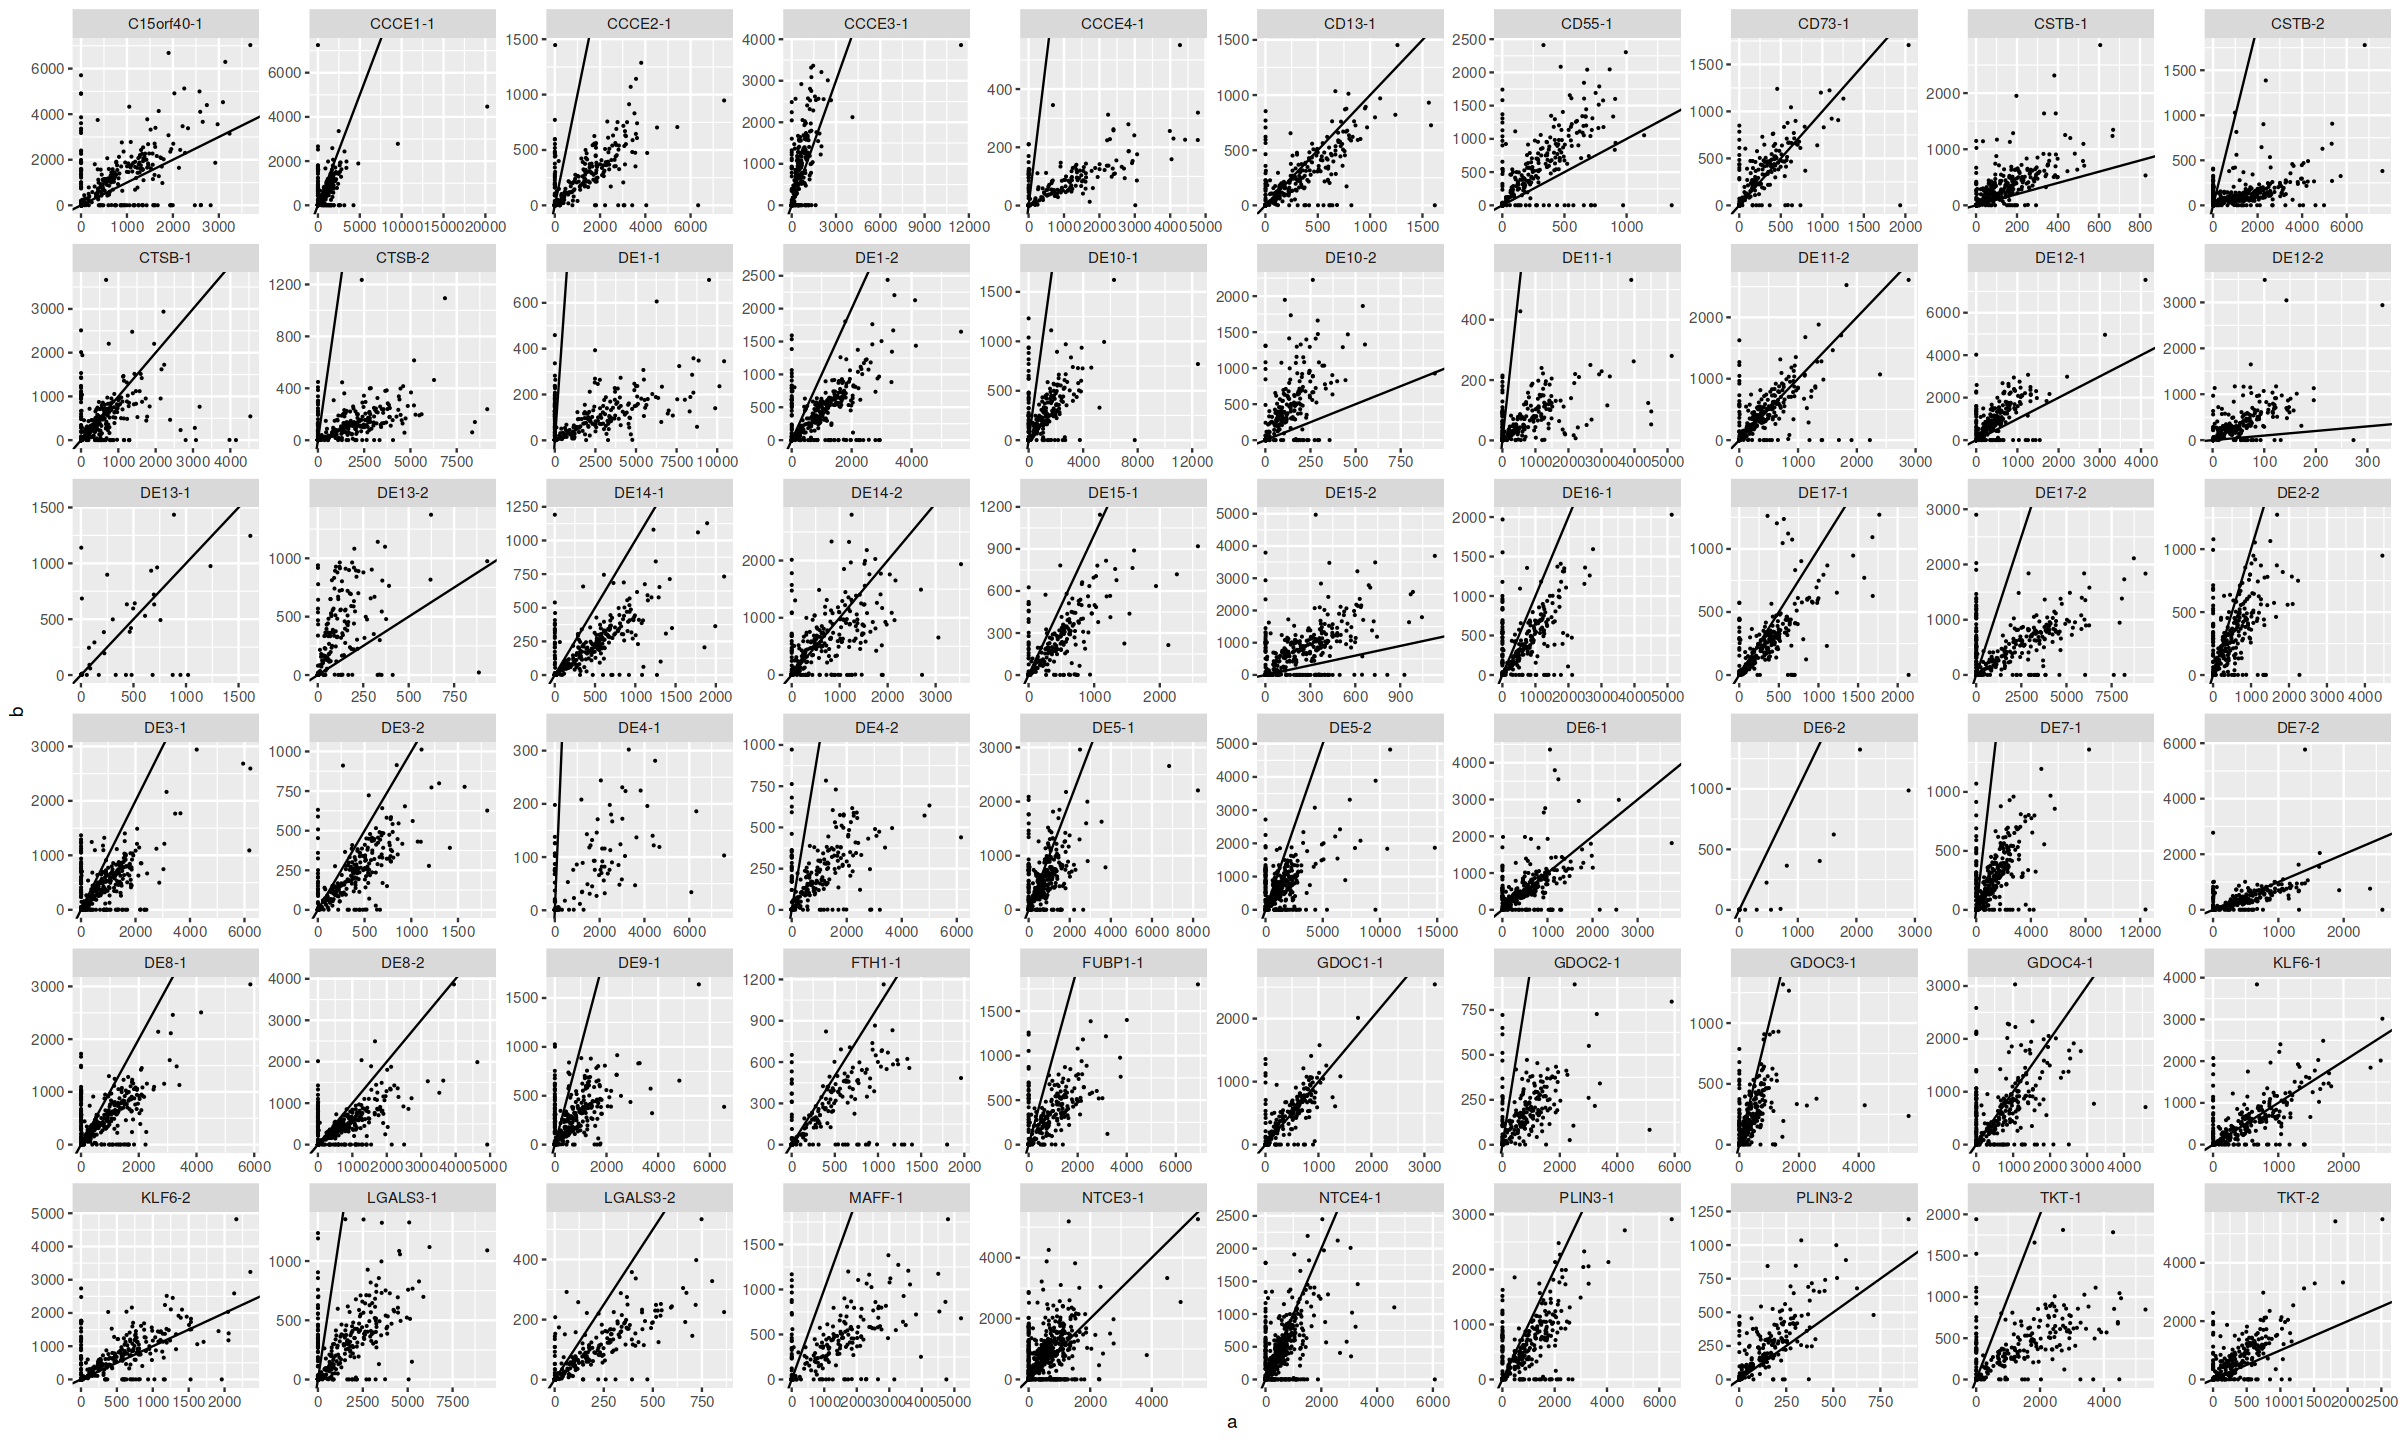

In [55]:
select_nonzero <- (df_pair$a > 0) & (df_pair$b > 0)
df_pair <- df_pair[select_nonzero, ]

options(repr.plot.width = 20, repr.plot.height = 12)

p1 <- ggplot(df_pair, aes(x = a, y = b)) +
    geom_point(size = .1) +
    geom_abline(slope = 1, intercept = 0) +
    facet_wrap(~PS, scales = "free", ncol = 10)

p1


### Visualize guide count distribution before guide calling

In [56]:
DefaultAssay(seurat) <- "sgRNA"
df_guide_counts <- as.data.frame(t(seurat[["sgRNA"]]@counts))
rownames(df_guide_counts) <- NULL
df_guide_counts$n_guides <- rowSums(df_guide_counts)


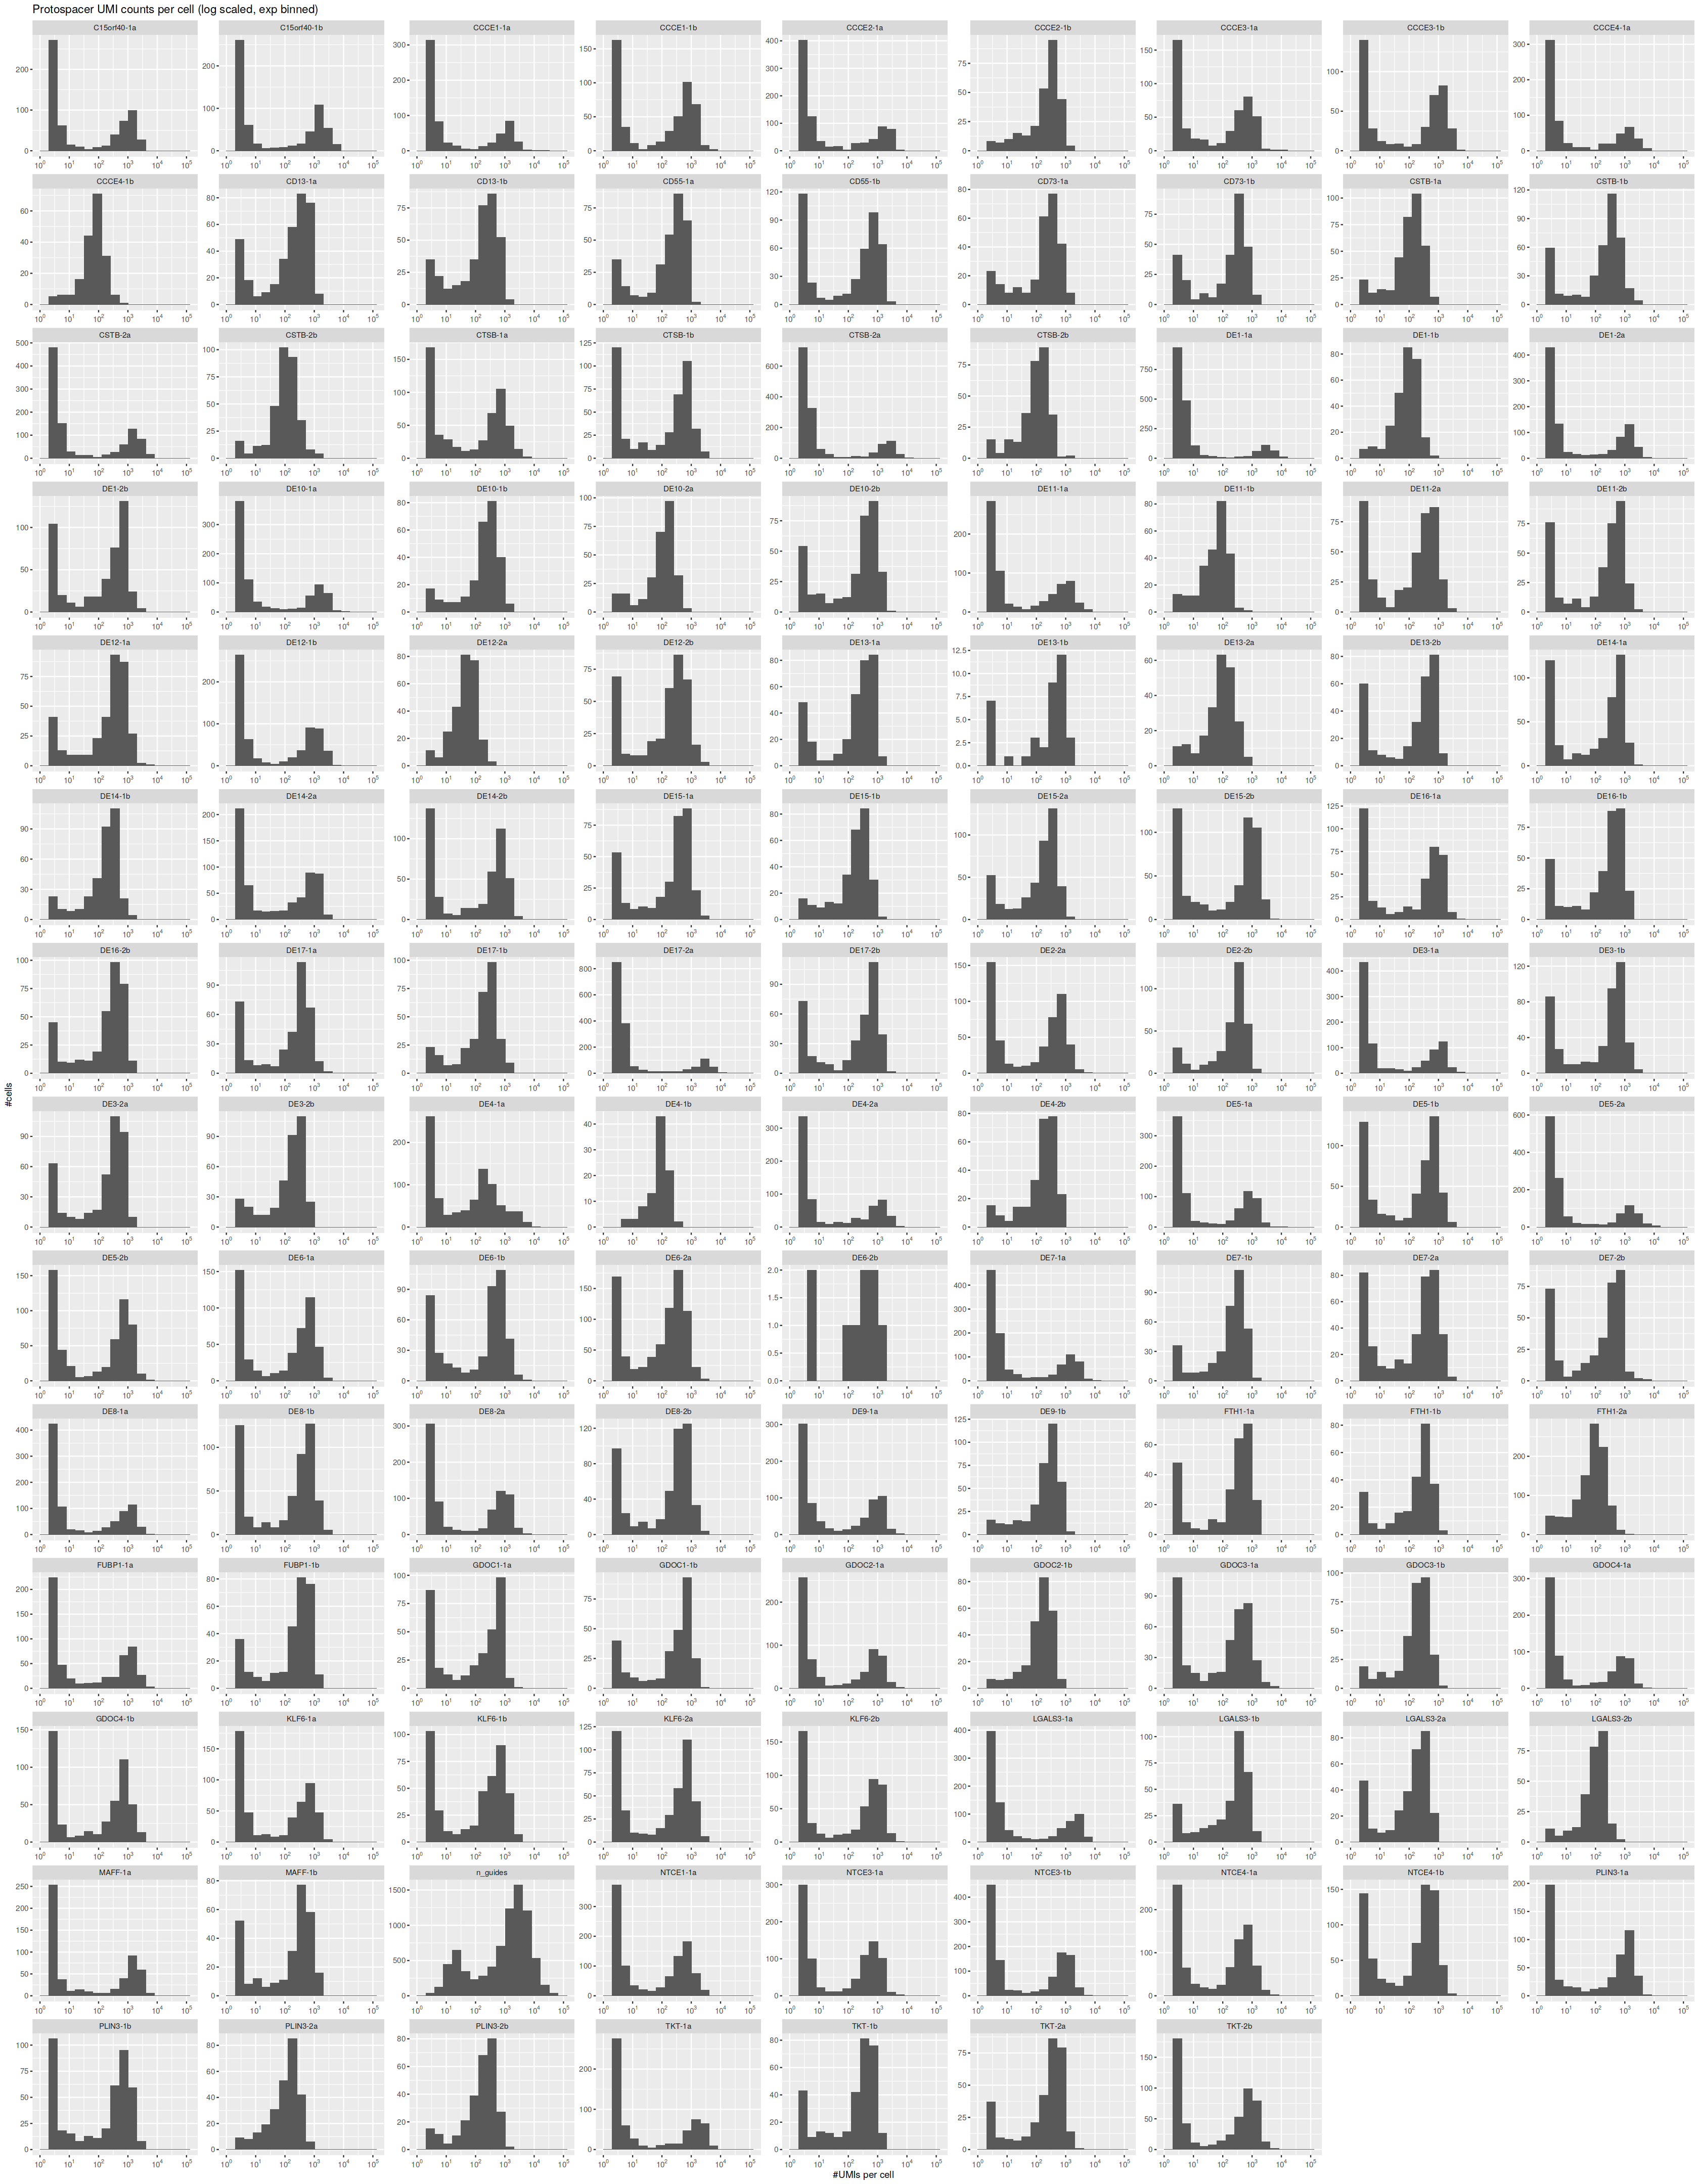

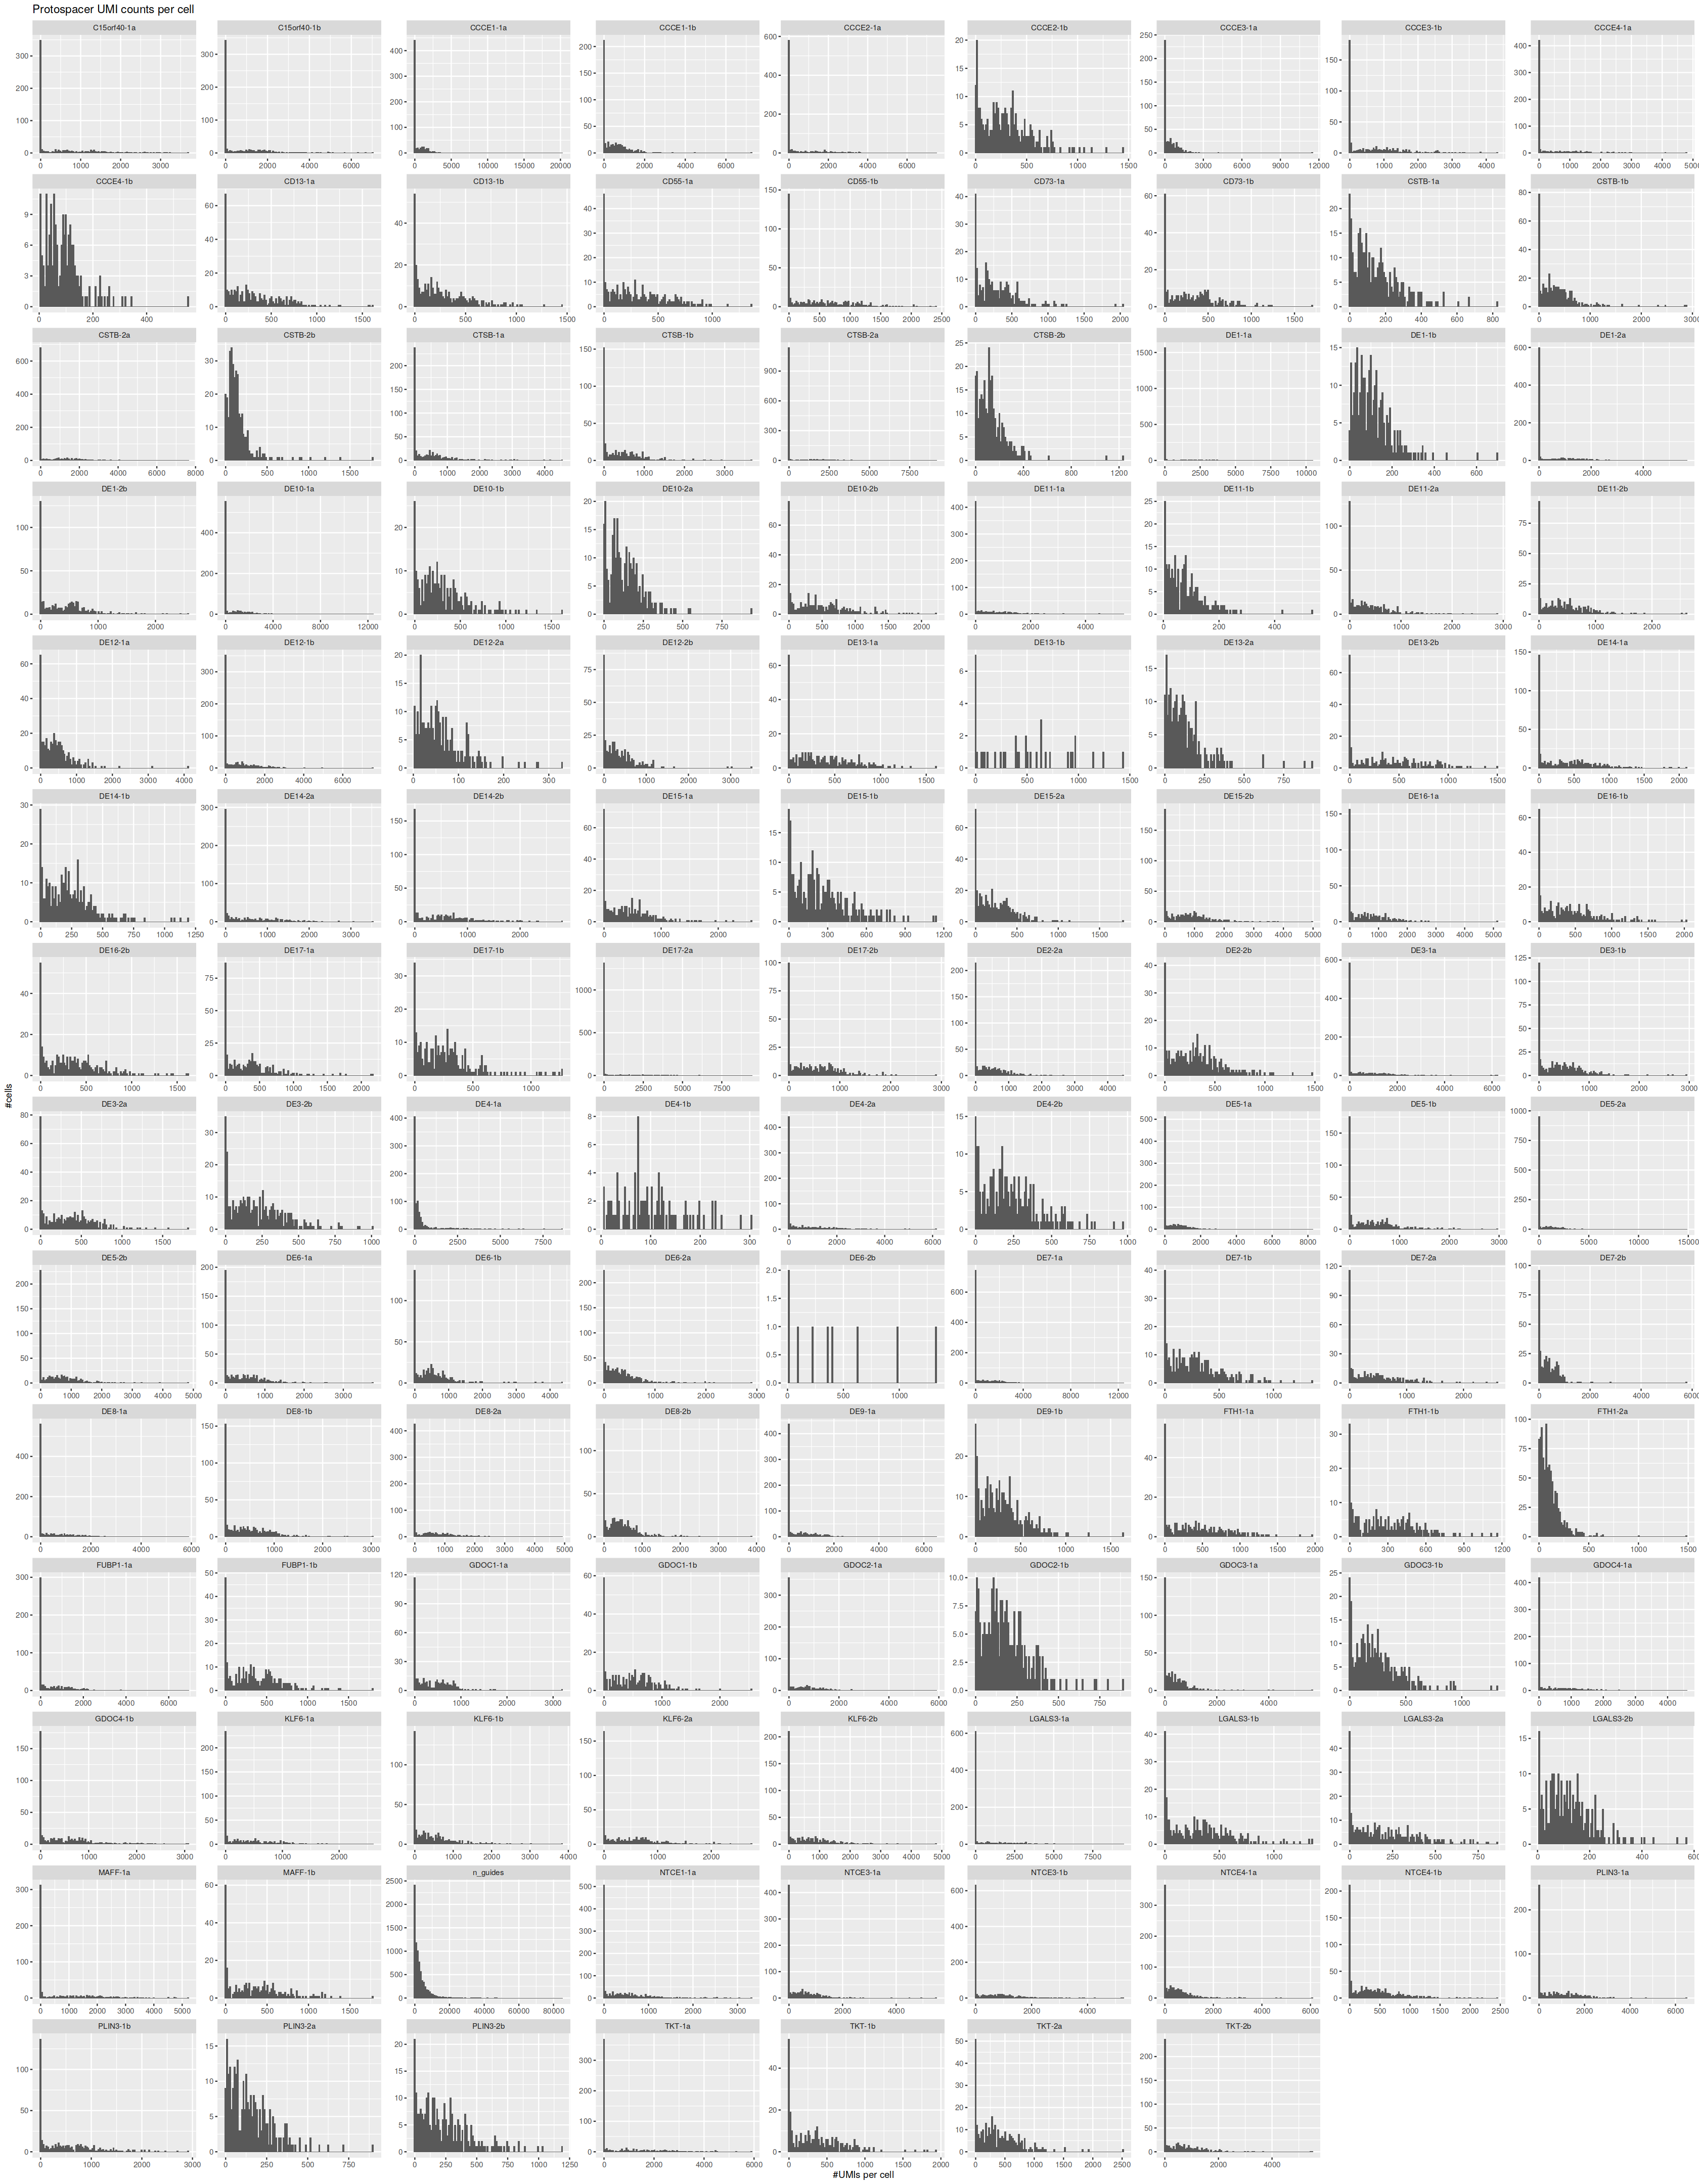

In [57]:
options(repr.plot.width = 28, repr.plot.height = 36)

data_long <- df_guide_counts %>%
  pivot_longer(colnames(df_guide_counts)) %>%
  as.data.frame()

filter_zeros <- data_long$value > 2
data_long <- data_long[filter_zeros, ]
bin_breaks <- c(1, 2, 2 * 2^(1:16))

ggp1 <- ggplot(data_long, aes(x = value)) + # Draw each column as histogram
  geom_histogram(breaks = bin_breaks) +
  scale_x_log10(
    labels = trans_format(
      "log10", math_format(10^.x)
    ), breaks = c(1, 10, 100, 1000, 10000, 100000)
  ) +
  labs(
    title = "Protospacer UMI counts per cell (log scaled, exp binned)",
    x = "#UMIs per cell",
    y = "#cells"
  ) +
  facet_wrap(~name, scales = "free", ncol = 9)

ggp2 <- ggplot(data_long, aes(x = value)) + # Draw each column as histogram
  geom_histogram(bins = 100) +
  labs(
    title = "Protospacer UMI counts per cell",
    x = "#UMIs per cell", y = "#cells"
  ) +
  facet_wrap(~name, scales = "free", ncol = 9)

ggp1
ggp2


# Load Souporcell outputs

In [58]:
df_soup <- read.csv(souporcell_clusters_path, sep = "\t")
head(df_soup, 2)
sum(df_soup == "singlet")


barcode            status  assignment log_prob_singleton log_prob_doublet
1 AAACCCAAGAGCAGCT-1 singlet 3           -695               -837           
2 AAACCCAAGCCGGAAT-1 doublet 1/2        -6694              -4669           
  cluster0 cluster1 cluster2 cluster3
1 -2104    -2279    -2433      -695  
2 -8876    -6694    -6876    -11522

[1] 8171

## Assign singlet/doublet status to Seurat cells

In [59]:
df_meta <- seurat@meta.data
df_meta$barcode <- rownames(df_meta)
df_assignment <- subset(df_soup, select = c("barcode", "status", "assignment"))

df_dummy <- inner_join(df_meta, df_assignment, by = "barcode")
nrow(df_meta)
nrow(df_dummy)


[1] 8015

[1] 8015

In [60]:
seurat$status <- df_dummy$status
seurat$donor <- df_dummy$assignment


Check if join worked ok

In [61]:
rownames(df_soup) <- df_soup$barcode
any(df_soup[rownames(seurat@meta.data), "status"] != seurat@meta.data$status)


[1] FALSE

Get souporcell assginment counts

In [62]:
table(df_soup$status)



   doublet    singlet unassigned 
       918       8171         80 

### Eliminate doublets

How many doublets among the filtered cells? 

In [63]:
select_doublets <- (df_soup$status == "doublet")
doublet_cells <- df_soup[select_doublets, ]$barcode
seurat_cells <- Cells(seurat)

select_singlets <- (df_soup$status == "singlet")
singlet_cells <- df_soup[select_singlets, ]$barcode
seurat <- subset(seurat, cells = singlet_cells)

stats[["Doublets_in_filtered_cells"]] <-
    length(intersect(doublet_cells, seurat_cells))
stats[["Total_doublets_before_filtering"]] <-
    length(doublet_cells)
stats[["Singlets_after_filtering"]] <-
    length(Cells(seurat))
stats[["Singlets_perc_after_filtering"]] <-
    round(length(Cells(seurat)) / length(seurat_cells), 2)


### Add stats into the misc slot

In [64]:
Misc(seurat, slot = "stats") <- stats


In [65]:
unique(seurat$status)


[1] "singlet"

#### Add dCas9 counts to metadata

In [66]:
barcodes <- rownames(seurat@meta.data)
seurat$dCas9 <- t(seurat[["RNA"]]["dCas9", ])[barcodes, ]


# Save to Seurat H5

In [67]:
if (save_seurat_h5 == "YES") {
    print("Saving h5...")
    SaveH5Seurat(
        seurat,
        filename = save_h5_file,
        overwrite = TRUE,
        verbose = FALSE
    )
}


# Stats

In [69]:
for (stat in names(stats)) {
    cat(blue(stat), ":", stats[[stat]], "\n")
}


Screen : Screen1_66guides 
Library : Lib_1 
Cells_recovered : 9183 
Genes_recovered : 31871 
Protospacers_in_assay : 132 
Max_mito_perc_threshold : 17 
Min_mito_perc_threshold : 3 
Max_n_RNA_threshold : 98499 
Min_n_RNA_threshold : -22205 
Max_n_genes_threshold : 12196 
Min_n_genes_threshold : 2000 
Cells_after_QC_filtering : 8015 
Cells_with_sgRNA_count_less_than_100 : 1786 
Doublets_in_filtered_cells : 719 
Total_doublets_before_filtering : 918 
Singlets_after_filtering : 7295 
Singlets_perc_after_filtering : 0.91 


In [70]:
stats_fname <- paste0(stats_out_path, library_name, "_stats.tsv")
dir.create(stats_out_path, showWarnings = FALSE)
write.table(
    stats,
    file = stats_fname,
    quote = FALSE,
    sep = "\t",
    col.names = NA
)


In [71]:
unique(subset(seurat, cells = singlet_cells)$status)
unique(seurat$status)


[1] "singlet"

[1] "singlet"

#  Clustering QC

## Is clustering driven by UMI counts?

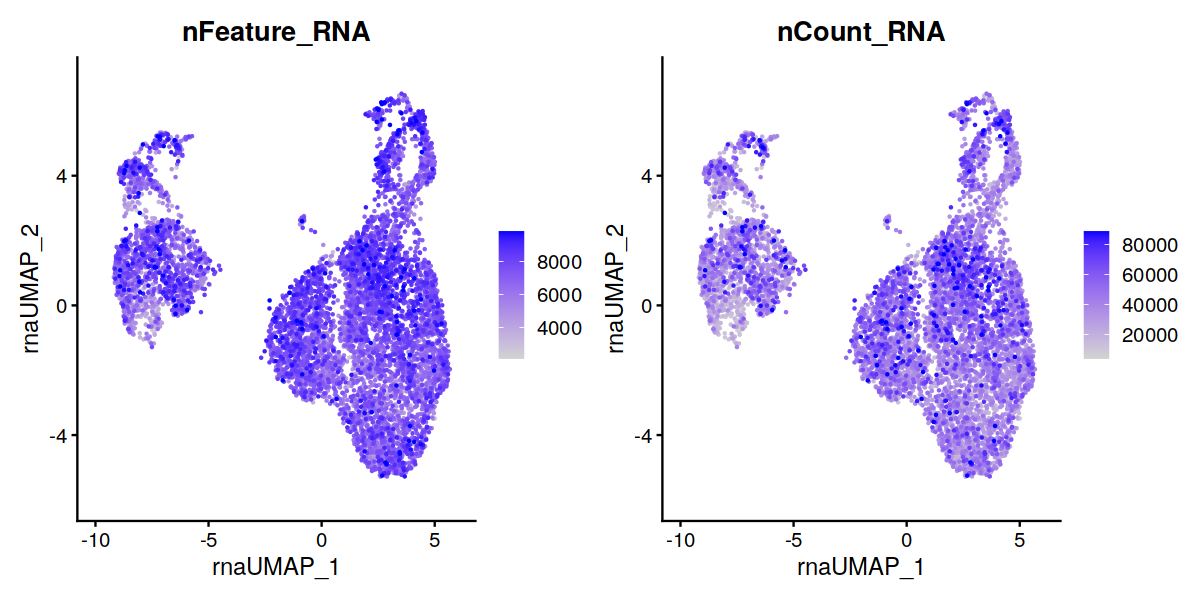

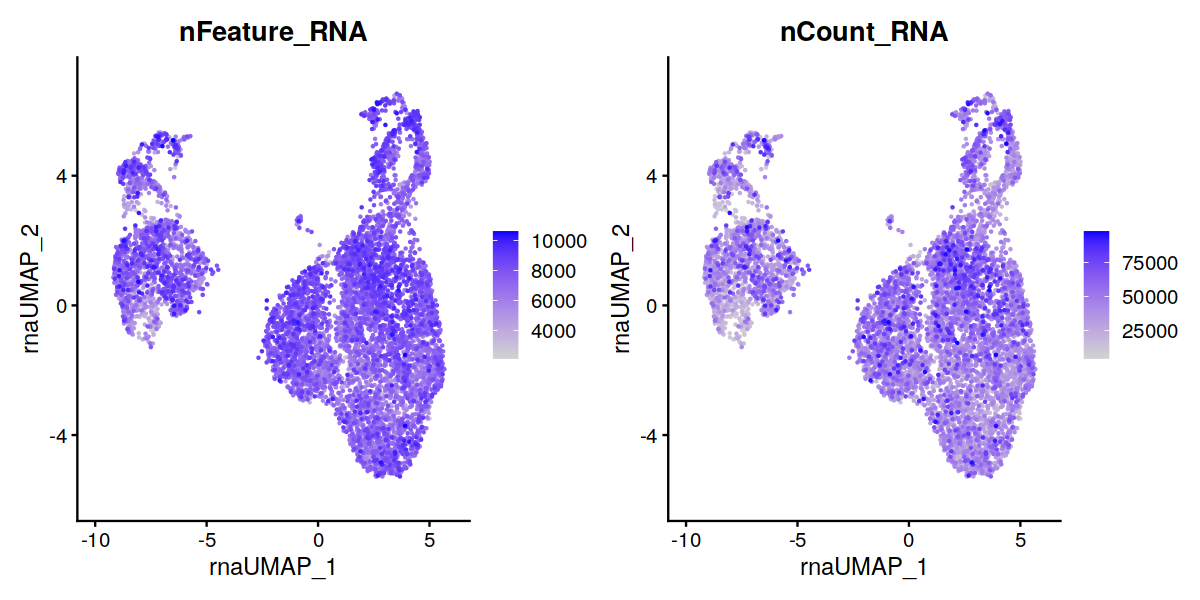

In [72]:
options(repr.plot.width = 10, repr.plot.height = 5)
FeaturePlot(
    seurat,
    reduction = "umap.rna",
    features = c("nFeature_RNA", "nCount_RNA"),
    min.cutoff = NA,
    max.cutoff = "q99",
    ncol = 2,
    order = T
)
FeaturePlot(
    seurat,
    reduction = "umap.rna",
    features = c("nFeature_RNA", "nCount_RNA"),
    min.cutoff = NA,
    max.cutoff = NA,
    ncol = 2,
    order = T
)


### Check if mito reads are driving the clustering

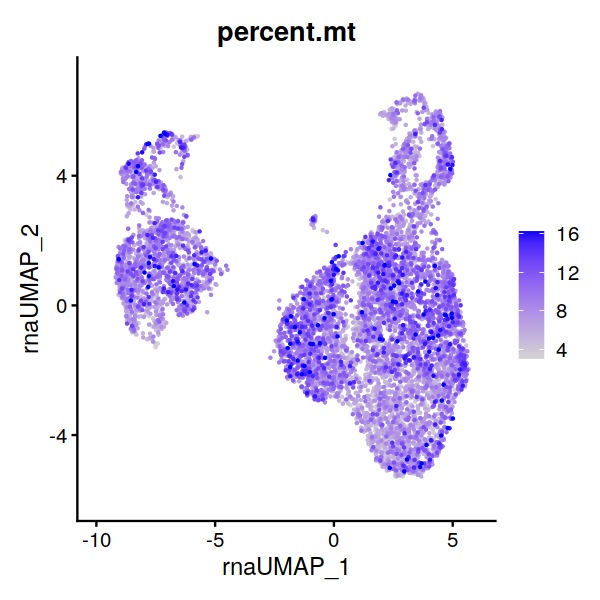

In [73]:
options(repr.plot.width = 5, repr.plot.height = 5)
FeaturePlot(
    seurat,
    reduction = "umap.rna",
    features = c("percent.mt"),
    min.cutoff = NA,
    max.cutoff = "q99",
    order = T
)


# Stop

In [74]:
quit(save = "no")


# -------

# Check the effect of the cell cycle

In [75]:
s.genes <- cc.genes$s.genes
g2m.genes <- cc.genes$g2m.genes


In [76]:
seurat <- CellCycleScoring(
    seurat,
    s.features = s.genes,
    g2m.features = g2m.genes,
    set.ident = TRUE,
    assay = "SCT"
)


Warning message:
"The following features are not present in the object: MLF1IP, not searching for symbol synonyms"
Warning message:
"The following features are not present in the object: FAM64A, HN1, not searching for symbol synonyms"


Regress out the cell cycle effects

In [77]:
# DefaultAssay(seurat) <- "RNA"
# seurat <- SCTransform(
#     seurat,
#     vst.flavor = "v2",
#     verbose = FALSE,
#     vars.to.regress = c('S.Score', 'G2M.Score')
# )  %>%
#     RunPCA(features = c(s.genes, g2m.genes)) %>%
#     RunUMAP(dims = 1:40, reduction.name = 'umap.rna', reduction.key = 'rnaUMAP_', verbose=FALSE)


Alternatively use this

In [78]:
# seurat <- RunPCA(seurat, features = c(s.genes, g2m.genes))


Picking joint bandwidth of 0.12

Picking joint bandwidth of 0.154

Picking joint bandwidth of 0.0868

Picking joint bandwidth of 0.101



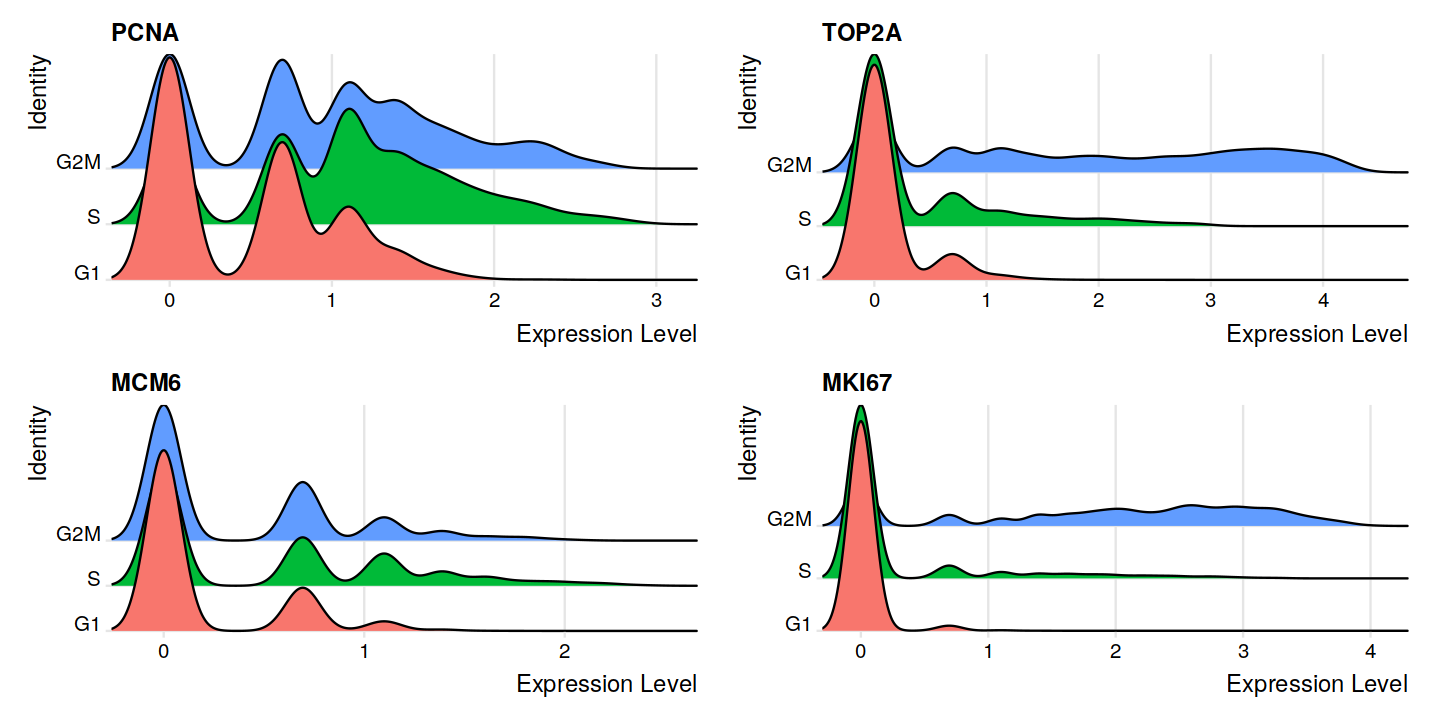

In [79]:
# Visualize the distribution of cell cycle markers across
options(repr.plot.width = 12, repr.plot.height = 6)
DefaultAssay(seurat) <- "SCT"
RidgePlot(seurat, features = c("PCNA", "TOP2A", "MCM6", "MKI67"), ncol = 2)


In [80]:
length(s.genes)
length(g2m.genes)


[1] 43

[1] 54

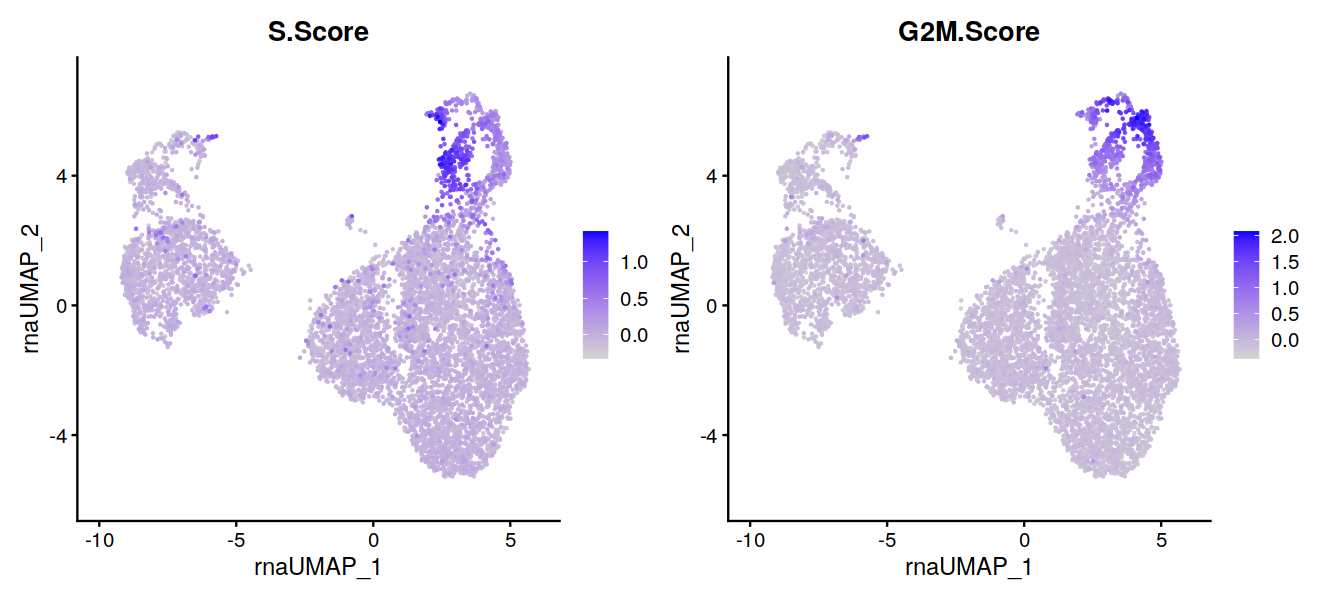

In [81]:
options(repr.plot.width = 11, repr.plot.height = 5)
FeaturePlot(
    seurat,
    reduction = "umap.rna",
    features = c("S.Score", "G2M.Score"),
    min.cutoff = NA,
    max.cutoff = NA,
    ncol = 2,
    order = T
)


Warning message in PrepDR(object = object, features = features, verbose = verbose):
"The following 28 features requested have not been scaled (running reduction without them): MCM5, MCM2, UNG, MCM6, CDCA7, PRIM1, MLF1IP, RFC2, RPA2, SLBP, UBR7, MSH2, RAD51, CDC45, EXO1, TIPIN, DSCC1, CASP8AP2, CHAF1B, FAM64A, HN1, RANGAP1, NCAPD2, PSRC1, CKAP5, CTCF, G2E3, CBX5"
PC_ 1 
Positive:  CENPF, MKI67, TOP2A, HMGB2, TPX2, DLGAP5, NUSAP1, HMMR, ANLN, GTSE1 
	   CKS2, CENPE, CDK1, UBE2C, BIRC5, KIF20B, RRM2, CDC20, SMC4, HJURP 
	   TUBB4B, AURKA, NUF2, TACC3, KIF2C, KIF11, CCNB2, KIF23, CLSPN, NDC80 
Negative:  POLD3, POLA1, CCNE2, GAS2L3, CDC6, WDR76, LBR, UHRF1, FEN1, PCNA 
	   DTL, BLM, USP1, GMNN, MCM4, GINS2, E2F8, CENPA, BRIP1, ANP32E 
	   CDC25C, RRM1, HELLS, ECT2, NASP, RAD51AP1, ATAD2, CKAP2, AURKB, CDCA3 
PC_ 2 
Positive:  CLSPN, ATAD2, HELLS, DTL, BRIP1, RRM2, WDR76, CDC6, NASP, CCNE2 
	   UHRF1, MCM4, GINS2, PCNA, POLA1, TYMS, FEN1, GMNN, E2F8, BLM 
	   USP1, RAD51AP1, POLD3, RRM1, TM

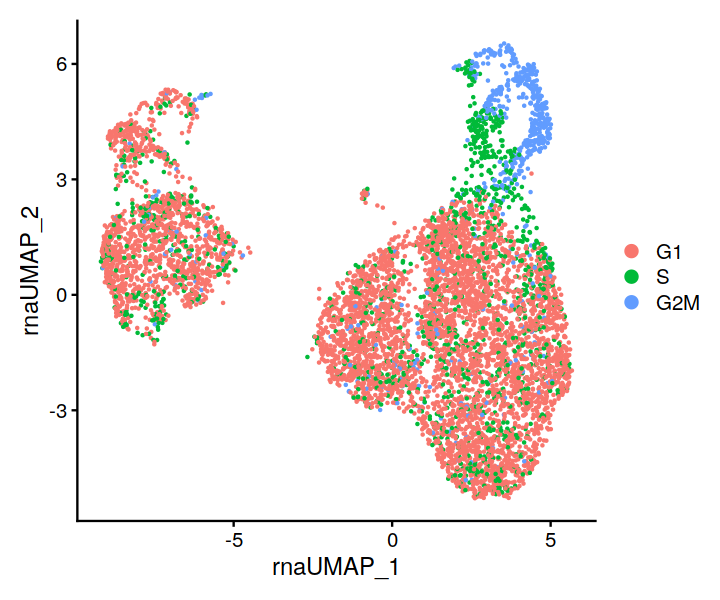

In [82]:
DefaultAssay(seurat) <- "SCT"
seurat_new <- RunPCA(seurat, npcs = 20, features = c(s.genes, g2m.genes))
options(repr.plot.width = 6, repr.plot.height = 5)
DimPlot(seurat)


# Visualize RNA count distribution

In [83]:
DefaultAssay(seurat) <- "SCT"
top_genes <- sample(VariableFeatures(seurat), 80)
DefaultAssay(seurat) <- "RNA"
df_rna_counts <- as.data.frame(t(seurat[["RNA"]]@counts[top_genes, ]))
rownames(df_rna_counts) <- NULL
df_rna_counts$n_rna <- rowSums(df_rna_counts)


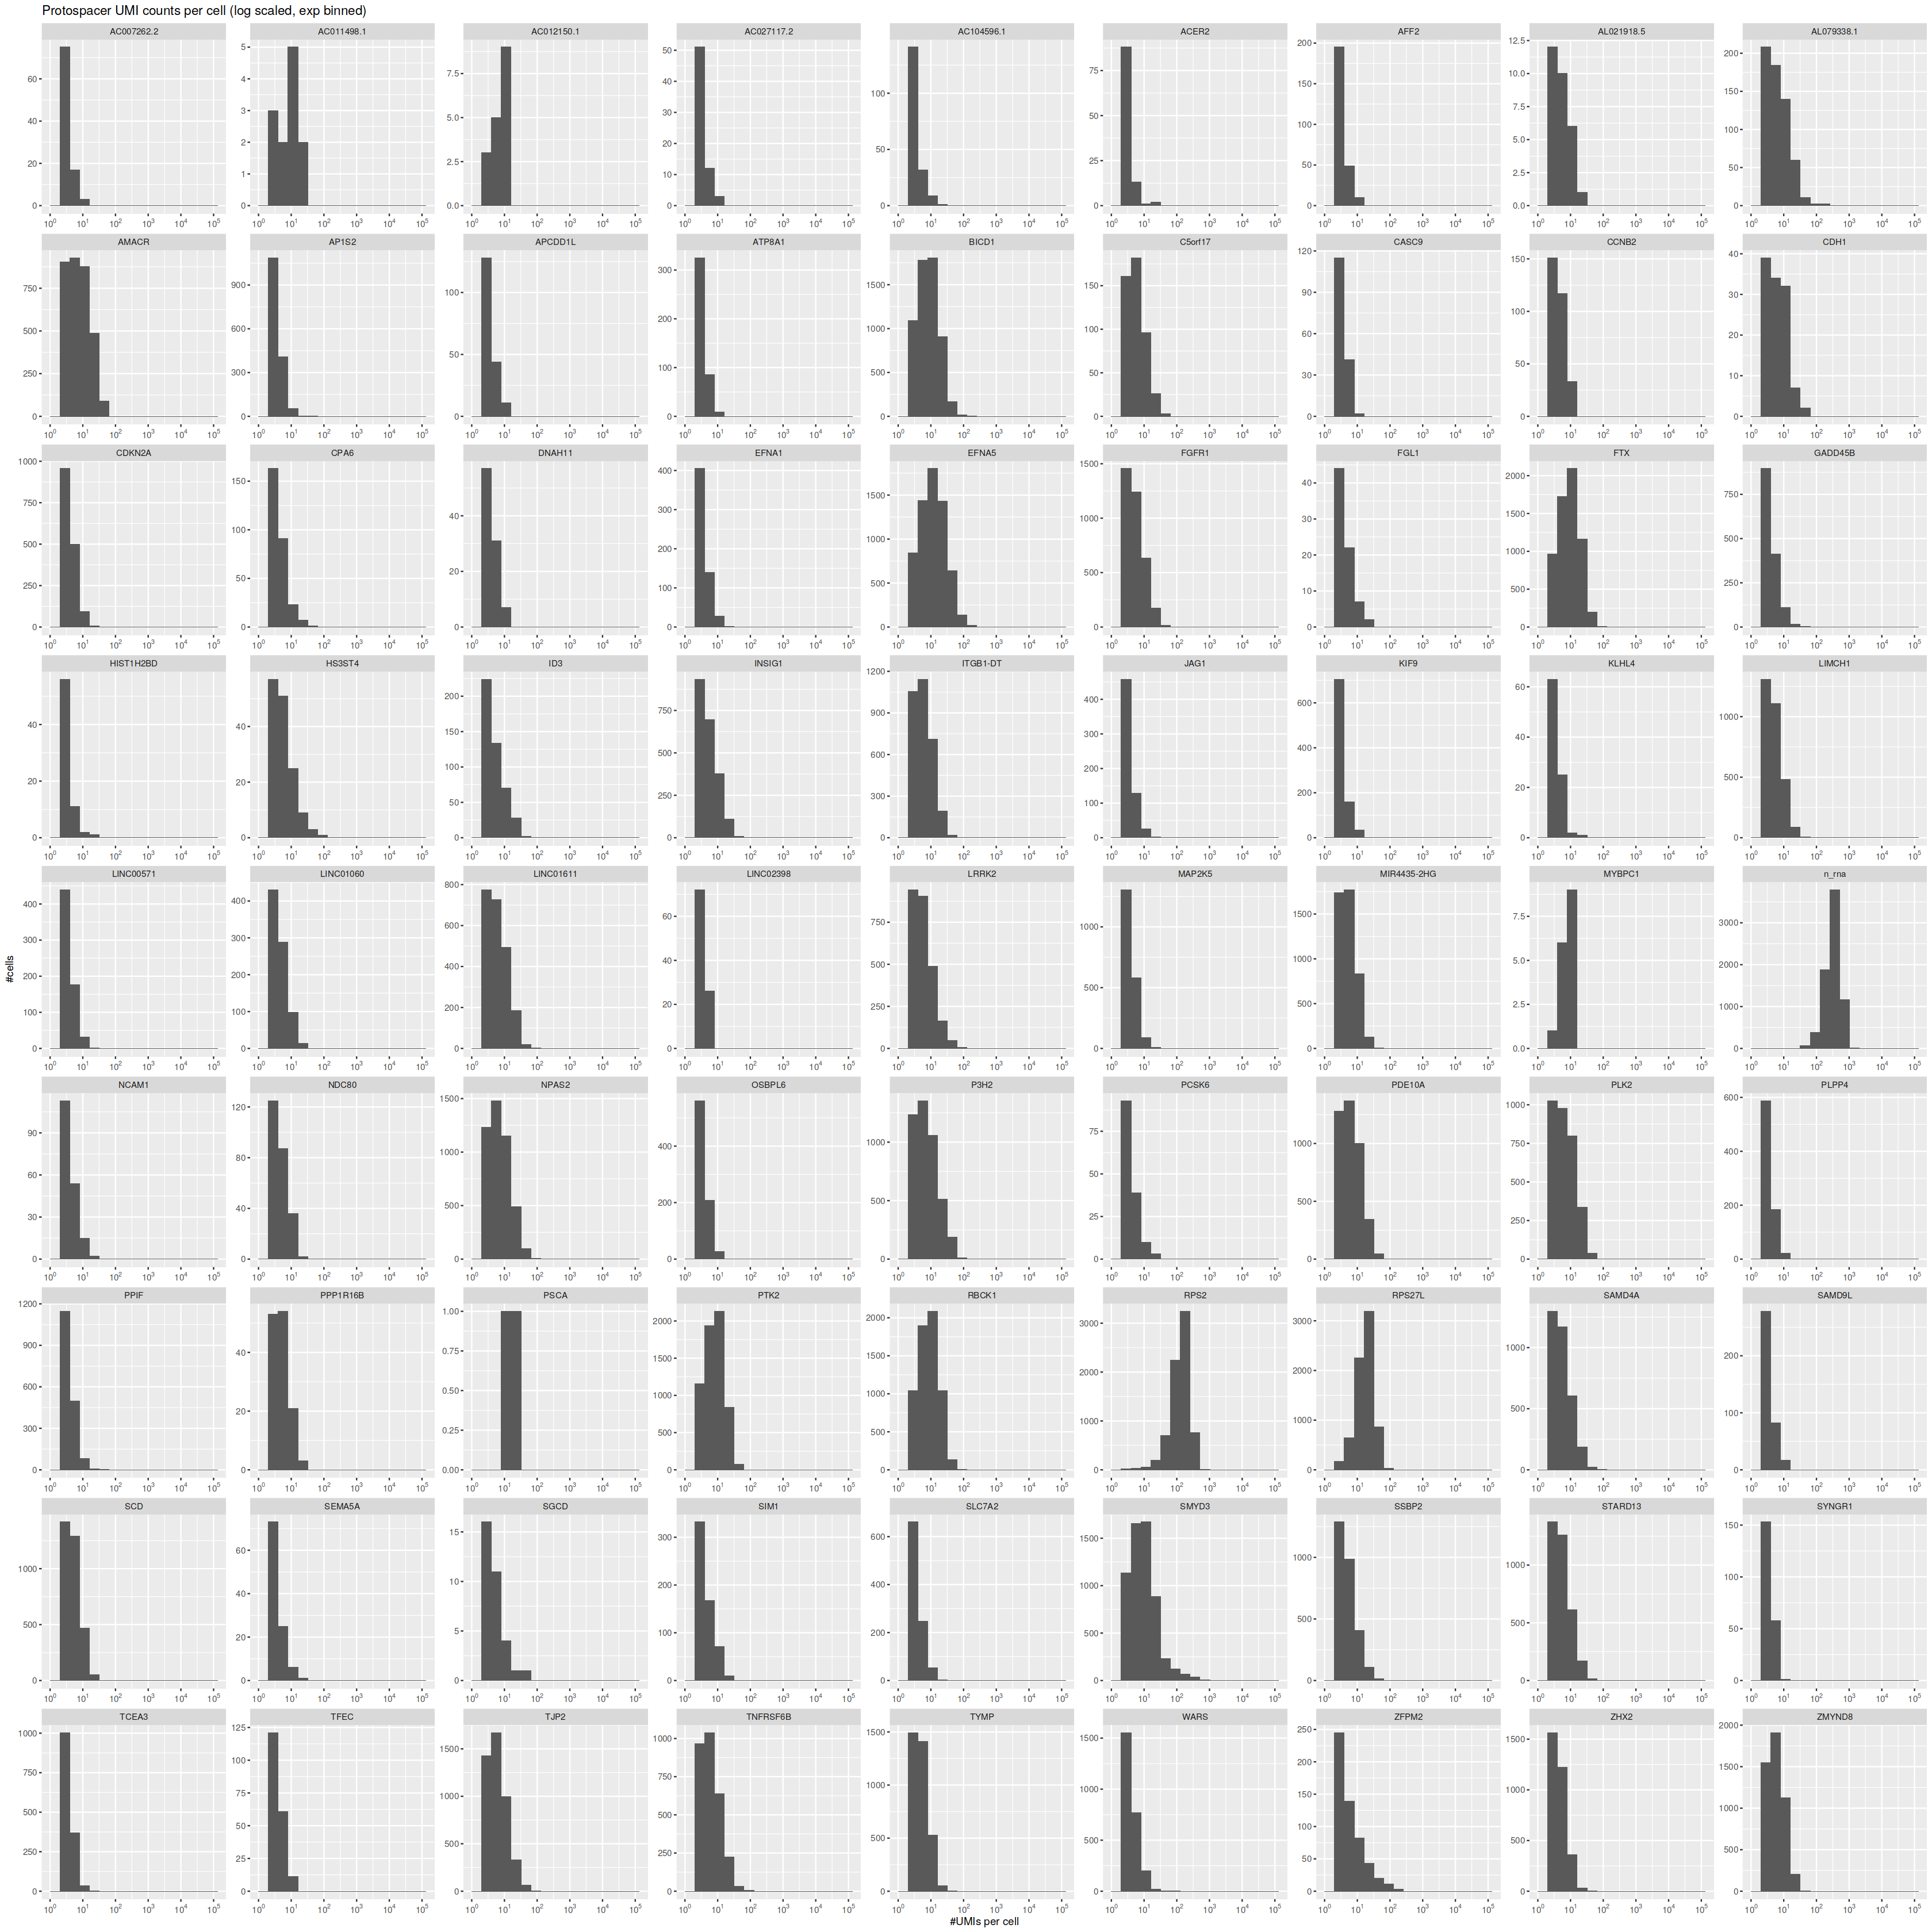

In [84]:
options(repr.plot.width = 28, repr.plot.height = 20)

data_long <- df_rna_counts %>%
  pivot_longer(colnames(df_rna_counts)) %>%
  as.data.frame()

filter_zeros <- data_long$value > 2
data_long <- data_long[filter_zeros, ]
bin_breaks <- c(1, 2, 2 * 2^(1:16))

ggp1 <- ggplot(data_long, aes(x = value)) + # Draw each column as histogram
  geom_histogram(breaks = bin_breaks) +
  scale_x_log10(
    labels = trans_format(
      "log10",
      math_format(10^.x)
    ), breaks = c(1, 10, 100, 1000, 10000, 100000)
  ) +
  labs(
    title = "Protospacer UMI counts per cell (log scaled, exp binned)",
    x = "#UMIs per cell",
    y = "#cells"
  ) +
  facet_wrap(~name, scales = "free", ncol = 9)

ggp2 <- ggplot(data_long, aes(x = value)) + # Draw each column as histogram
  geom_histogram(bins = 100) +
  labs(
    title = "Protospacer UMI counts per cell",
    x = "#UMIs per cell",
    y = "#cells"
  ) +
  facet_wrap(~name, scales = "free", ncol = 9)

options(repr.plot.width = 28, repr.plot.height = 28)
ggp1
# ggp2


# Number of guides vs dCas9 expression

Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Transformation introduced infinite values in continuous x-axis"


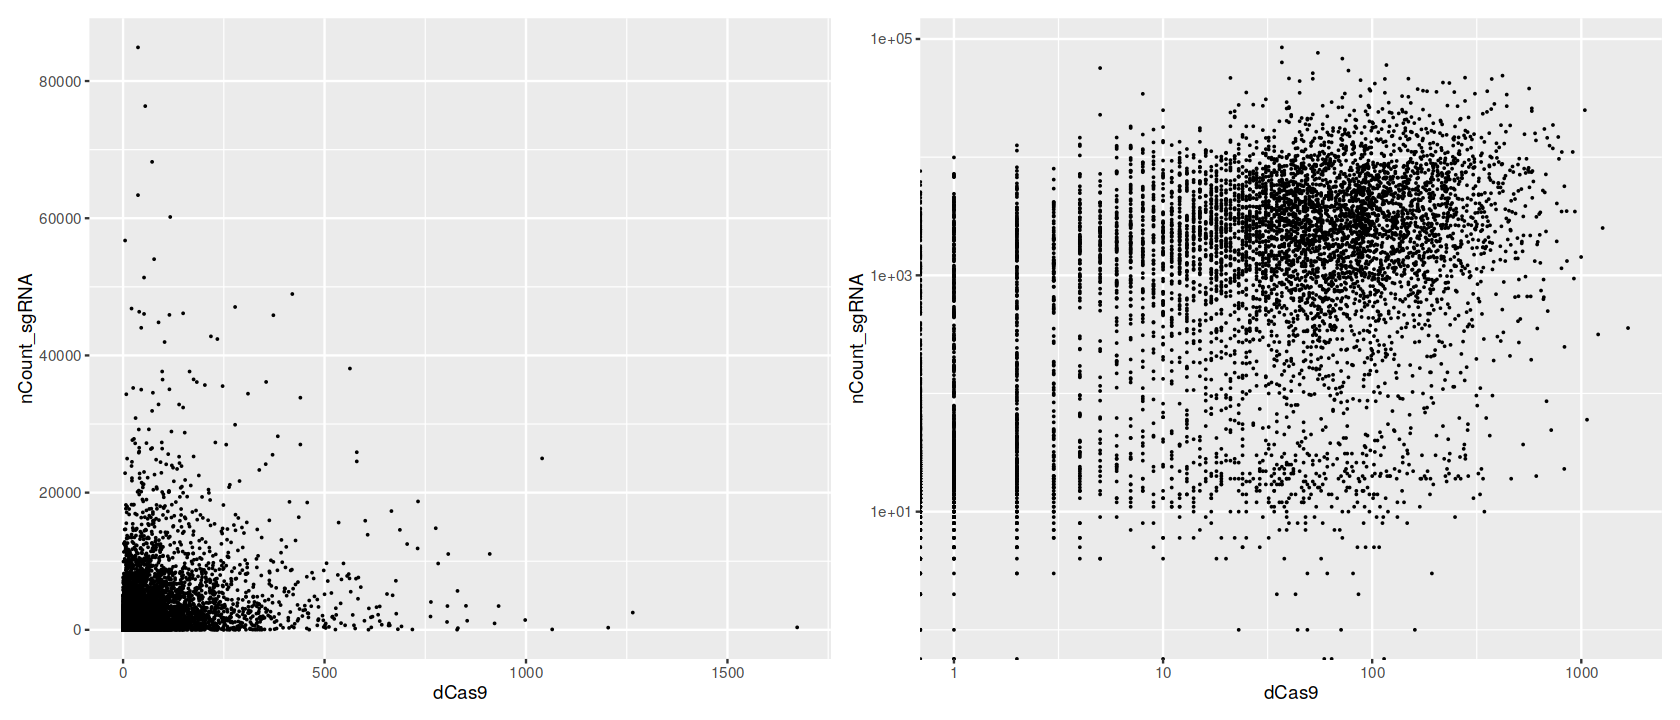

In [85]:
options(repr.plot.width = 14, repr.plot.height = 6)

ggplot(seurat@meta.data, aes(x = dCas9, nCount_sgRNA)) +
    geom_point(size = 0.01) +
    ggplot(seurat@meta.data, aes(x = dCas9, nCount_sgRNA)) +
    geom_point(size = 0.01) +
    scale_y_log10() +
    scale_x_log10()


In [86]:
cor(seurat$nCount_sgRNA, seurat$dCas9, method = "pearson")
cor(seurat$nCount_sgRNA, seurat$dCas9, method = "spearman")


[1] 0.21

[1] 0.48